# Trial End

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import pickle

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
# folders
raw_dir = '/home/brooke/pacman/raw_data'
preproc_dir = '/home/brooke/pacman/preprocessing'
tfr_dir = '/home/brooke/knight_server/remote/bstavel/pacman/preprocessing'

# load preproc functions
%run ../../preprocessing/scripts/preproc_functions.py

# subjects
sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL10', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

# conditions
conditions = ['chase_trial == 0 & died == 0', 'chase_trial == 1', 'died == 1']

In [3]:
def calculate_trial_end_average(sub_list, string_filters, roi):
    tfrs = []
    used_subs = []
    for subject in sub_list:

        try:
            if os.path.exists(f"{tfr_dir}/{subject}/ieeg/trial_end/{roi}-tfr.h5"):
                # load data
                used_subs.append(subject)
                
                # load data
                tmp_TFR = mne.time_frequency.read_tfrs(f"{tfr_dir}/{subject}/ieeg/trial_end/{roi}-tfr.h5")

                # zscore and log
                tmp_TFR = log_and_zscore_TFR(tmp_TFR[0], baseline = (-2.5,2.5), logflag=True)

                tfr_cases = []
                for case in string_filters:            
                    # filter
                    tfr_case = tmp_TFR[case]
                    # append
                    tfr_cases.append(tfr_case.data.mean(axis = 0).mean(axis = 0))

                # get mean and append
                tfrs.append(tfr_cases)

        except Exception as e:
            print(f"Failed to load {subject}")
            print(e)
            used_subs.remove(subject)
            continue

        print(f"currently used subs: {used_subs}")

    # save progress cuz it is so long to load these dang things       
    with open(f'../ieeg/trial_end_average_{roi}.pkl', 'wb') as f:
        pickle.dump(tfrs, f)                
        
    # invert list so the outer list is the string filter
    tfrs_cases = [[tfrs[j][i] for j in range(len(tfrs))] for i in range(len(tfrs[0]))]

    all_subs_averages = []
    for tfr_case in tfrs_cases:

        if any("LL" in subject for subject in sub_list):

            # get indicies of high/low samp rate subs
            first_ll_sub = [subject for subject in used_subs if "LL" in subject][0]
            ll_begin = used_subs.index(first_ll_sub)

            # high sampling rate
            washu_tfrs = np.asarray(tfr_case[0:ll_begin])
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # Low sampling rate
            ll_tfrs = np.asarray(tfr_case[ll_begin:])
            ll_tfrs_mean = ll_tfrs.mean(axis = 0)

            # combine
            all_subs_tfrs = np.stack((washu_tfrs_mean[:, ::2], ll_tfrs_mean[:, 0:2501]))
        
            # mean
            all_subs_average = all_subs_tfrs.mean(axis = 0)
            all_subs_averages.append(all_subs_average)
            
        else:
            
            # high sampling rate
            washu_tfrs = np.asarray(tfr_case)
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # mean
            all_subs_average = washu_tfrs_mean
            all_subs_averages.append(all_subs_average)    

    return all_subs_averages

def plot_allsub_averages(array_average, title, fname):
    plt.rcParams['figure.figsize'] = [45, 35]
    plt.rcParams.update({'font.size': 38})
    matplotlib.rcParams['font.serif'] = 'Times New Roman'
    matplotlib.rcParams['font.family'] = 'serif'

    freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
    yticks = np.linspace(np.min(freqs),np.max(freqs),len(freqs))
    yticks_labels = np.round(freqs, 1)

    fig, ax = plt.subplots()
    i = ax.imshow(array_average, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -1, vmax = 1)
    i2 = plt.axvline(x=0, color='black', linestyle='--')
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels(yticks_labels[::2])
    bar = plt.colorbar(i)
    ax.set_title(title, fontsize=65, fontweight = "bold", pad=40)
    fig.savefig(fname, dpi=400)

## Hippocampus

In [4]:
all_subs_average_hcs = calculate_trial_end_average(sub_list, conditions, 'hc')
all_subs_average_hc_escape = all_subs_average_hcs[0]
all_subs_average_hc_chase = all_subs_average_hcs[1]
all_subs_average_hc_die = all_subs_average_hcs[2]
    

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/trial_end/hc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/trial_end/hc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/trial_end/hc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/trial_end/hc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remo

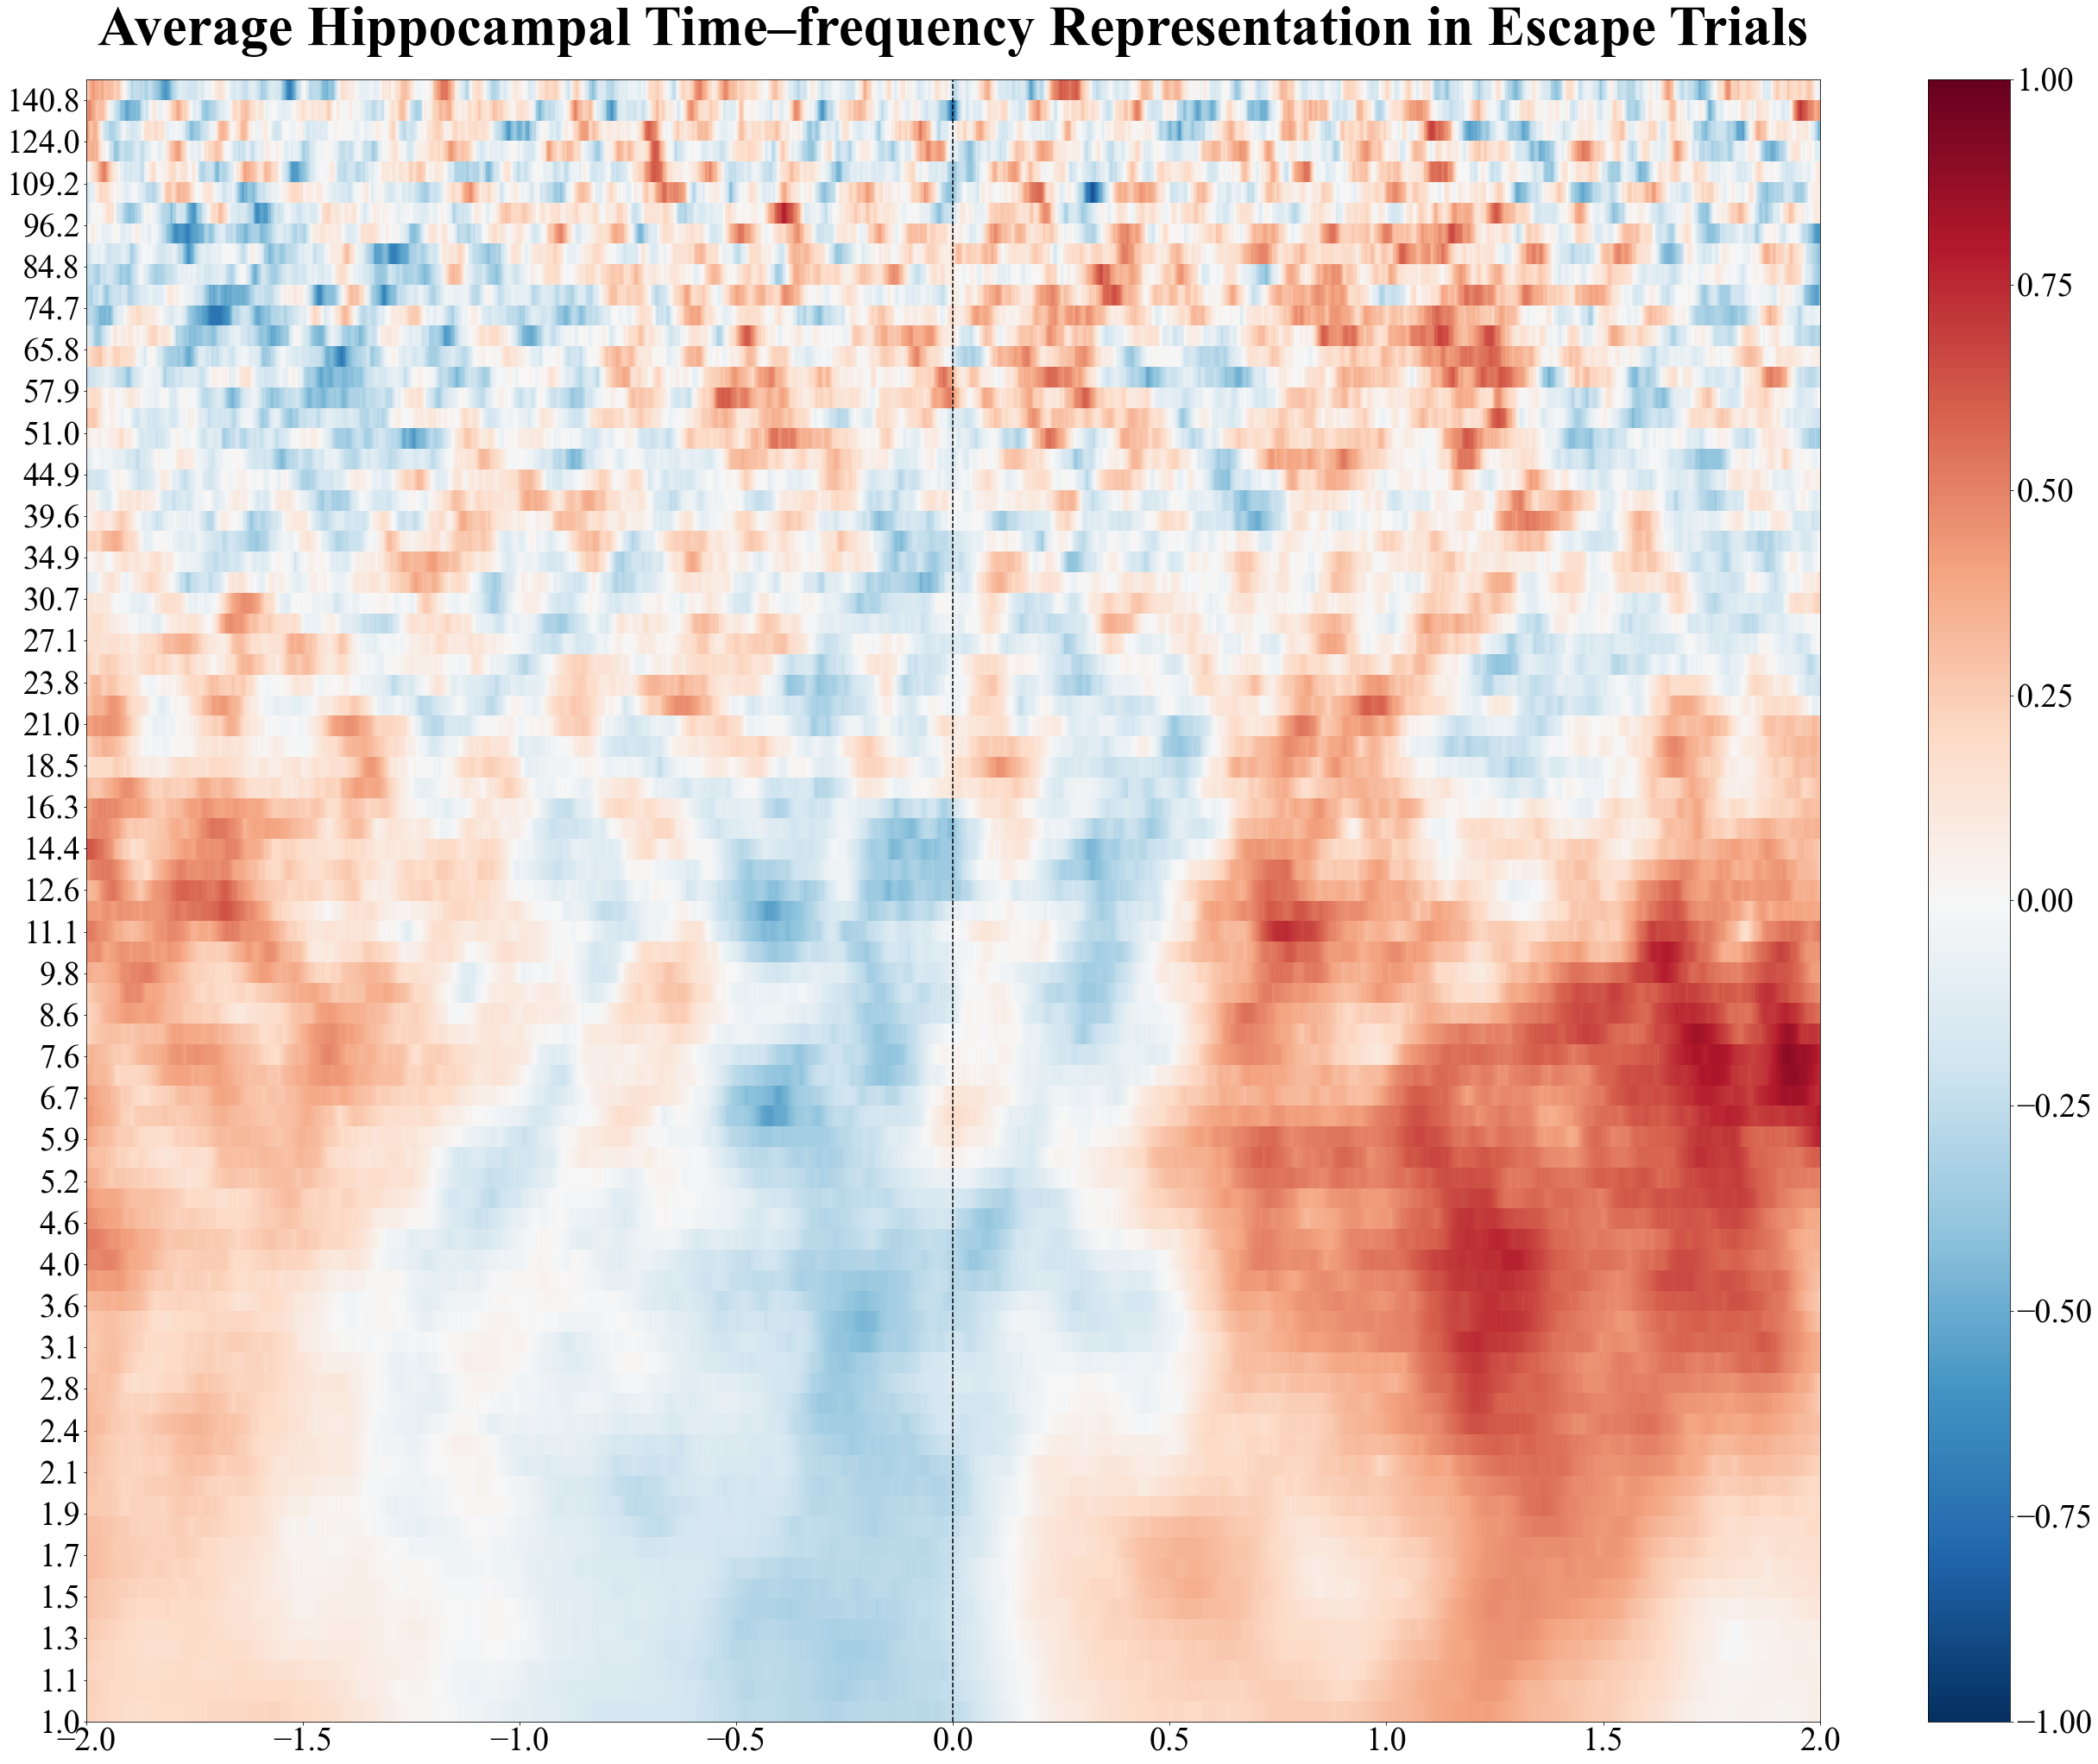

In [6]:
plot_allsub_averages(all_subs_average_hc_escape, "Average Hippocampal Time–frequency Representation in Escape Trials", 'average_hc_escape_all_subs.png')

In [6]:
plot_allsub_averages(all_subs_average_hc_chase, "Average Hippocampal Time–frequency Representation in Chase Trials", 'average_hc_chase_all_subs.png')

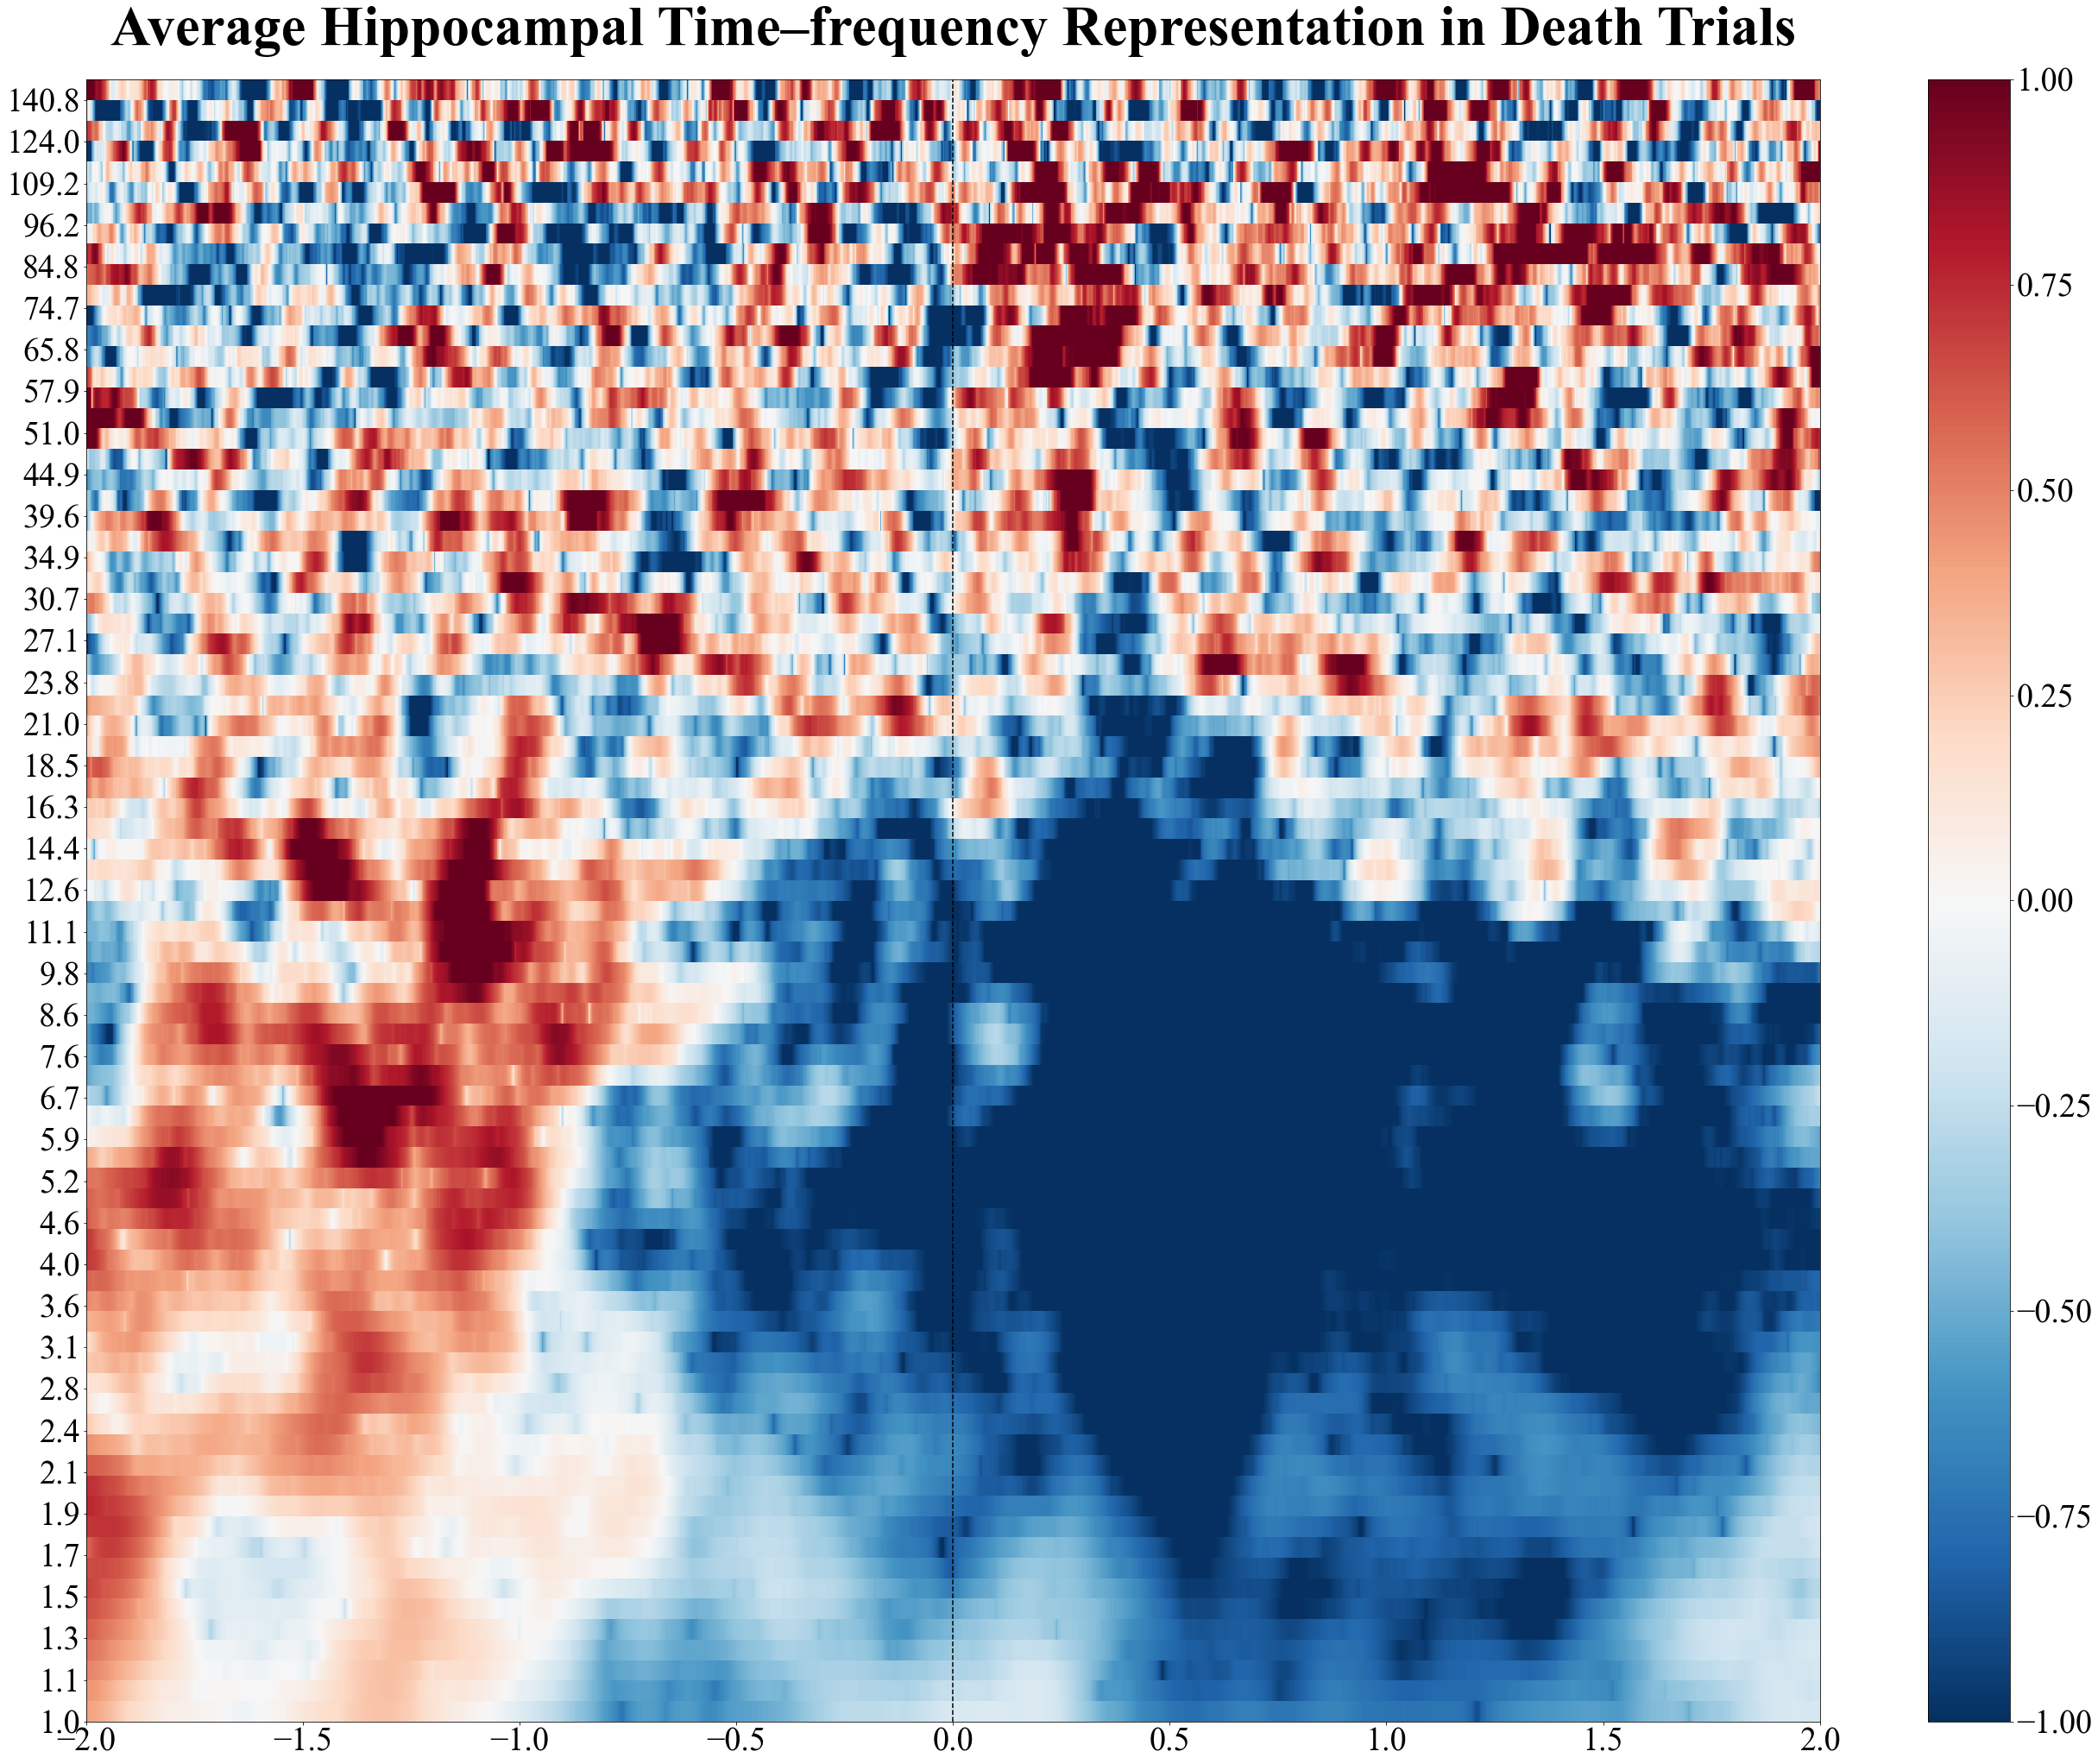

In [7]:
plot_allsub_averages(all_subs_average_hc_die, "Average Hippocampal Time–frequency Representation in Death Trials", 'average_hc_death_all_subs.png')

## OFC

In [8]:
all_subs_average_ofcs = calculate_trial_end_average(sub_list, conditions, 'ofc')
all_subs_average_ofc_escape = all_subs_average_ofcs[0]
all_subs_average_ofc_chase = all_subs_average_ofcs[1]
all_subs_average_ofc_die = all_subs_average_ofcs[2]

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/trial_end/ofc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/trial_end/ofc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/trial_end/ofc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/trial_end/ofc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/trial_end/ofc-t

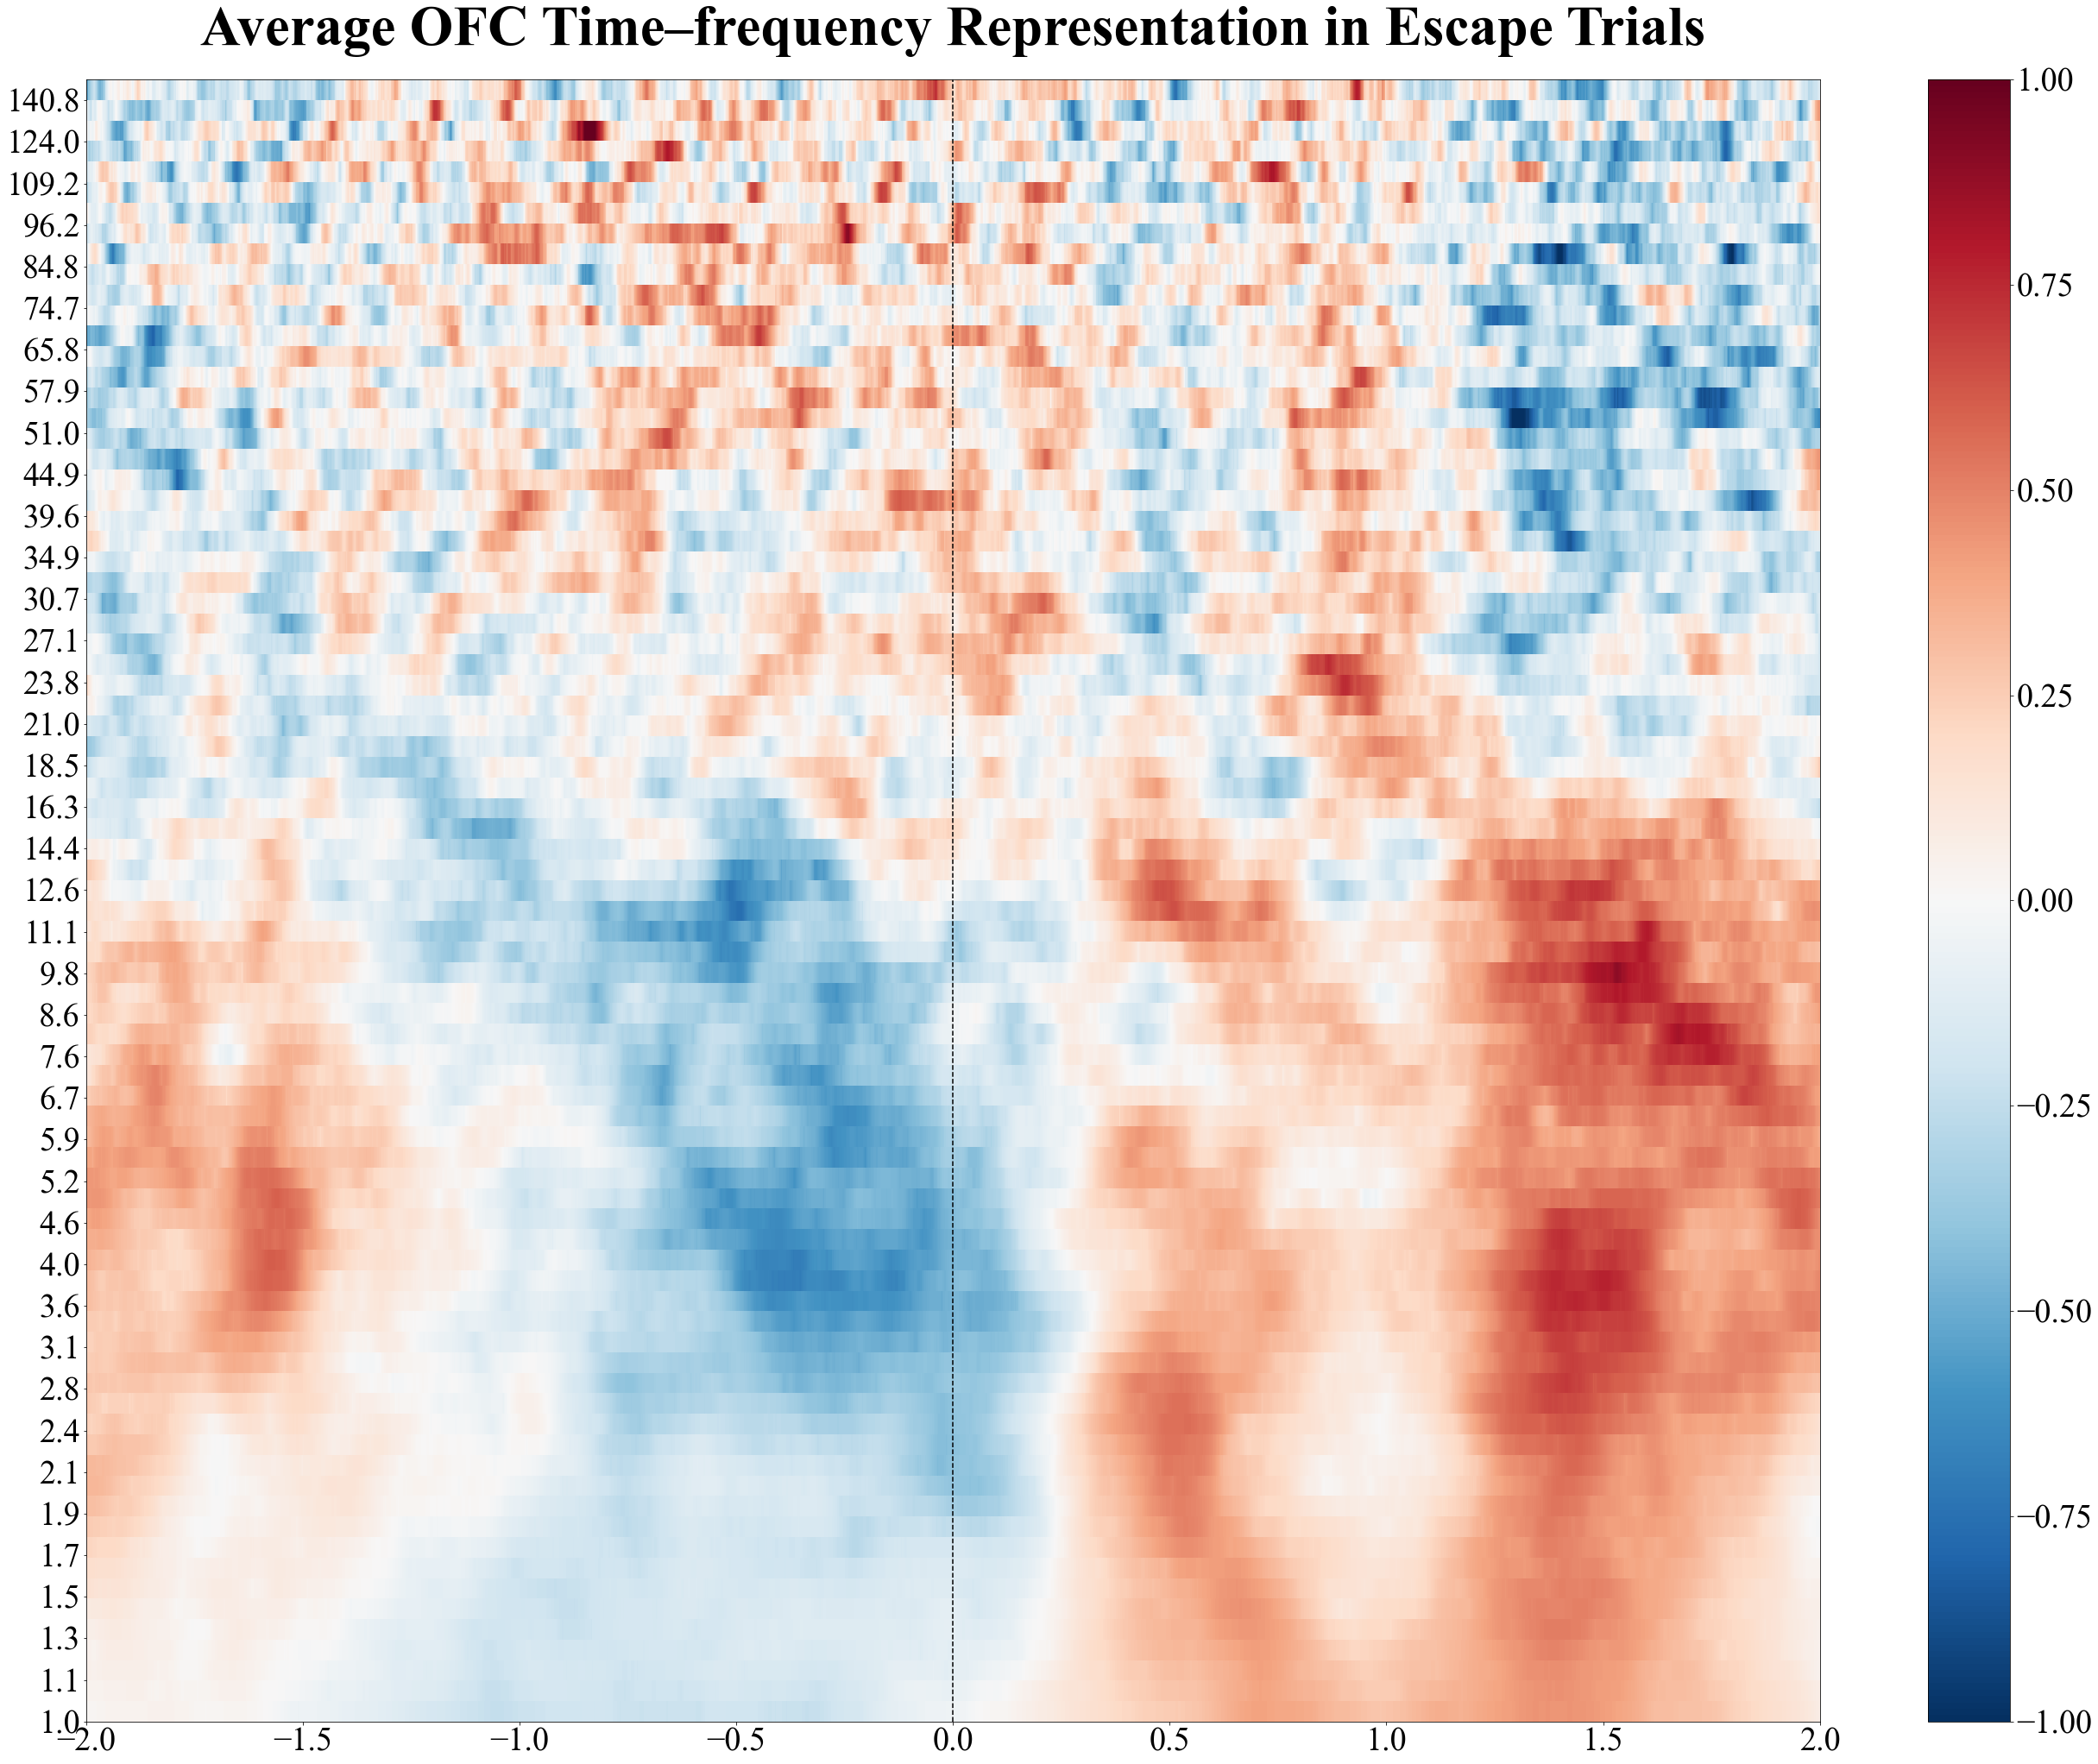

In [9]:
plot_allsub_averages(all_subs_average_ofc_escape, "Average OFC Time–frequency Representation in Escape Trials", 'average_ofc_escape_all_subs.png')

In [10]:
plot_allsub_averages(all_subs_average_ofc_chase, "Average OFC Time–frequency Representation in Chase Trials", 'average_ofc_chase_all_subs.png')

In [11]:
plot_allsub_averages(all_subs_average_ofc_die, "Average OFC Time–frequency Representation in Death Trials", 'average_ofc_death_all_subs.png')

## Anterior Cingulate

In [12]:
all_subs_average_cings = calculate_trial_end_average(sub_list, conditions, 'cing')
all_subs_average_cing_escape = all_subs_average_cings[0]
all_subs_average_cing_chase = all_subs_average_cings[1]
all_subs_average_cing_die = all_subs_average_cings[2]

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/trial_end/cing-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/trial_end/cing-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/trial_end/cing-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/trial_end/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/trial_end/c

In [13]:
plot_allsub_averages(all_subs_average_cing_escape, "Average Ant. Cingulate Time–frequency Representation in Escape Trials", 'average_cing_escape_all_subs.png')

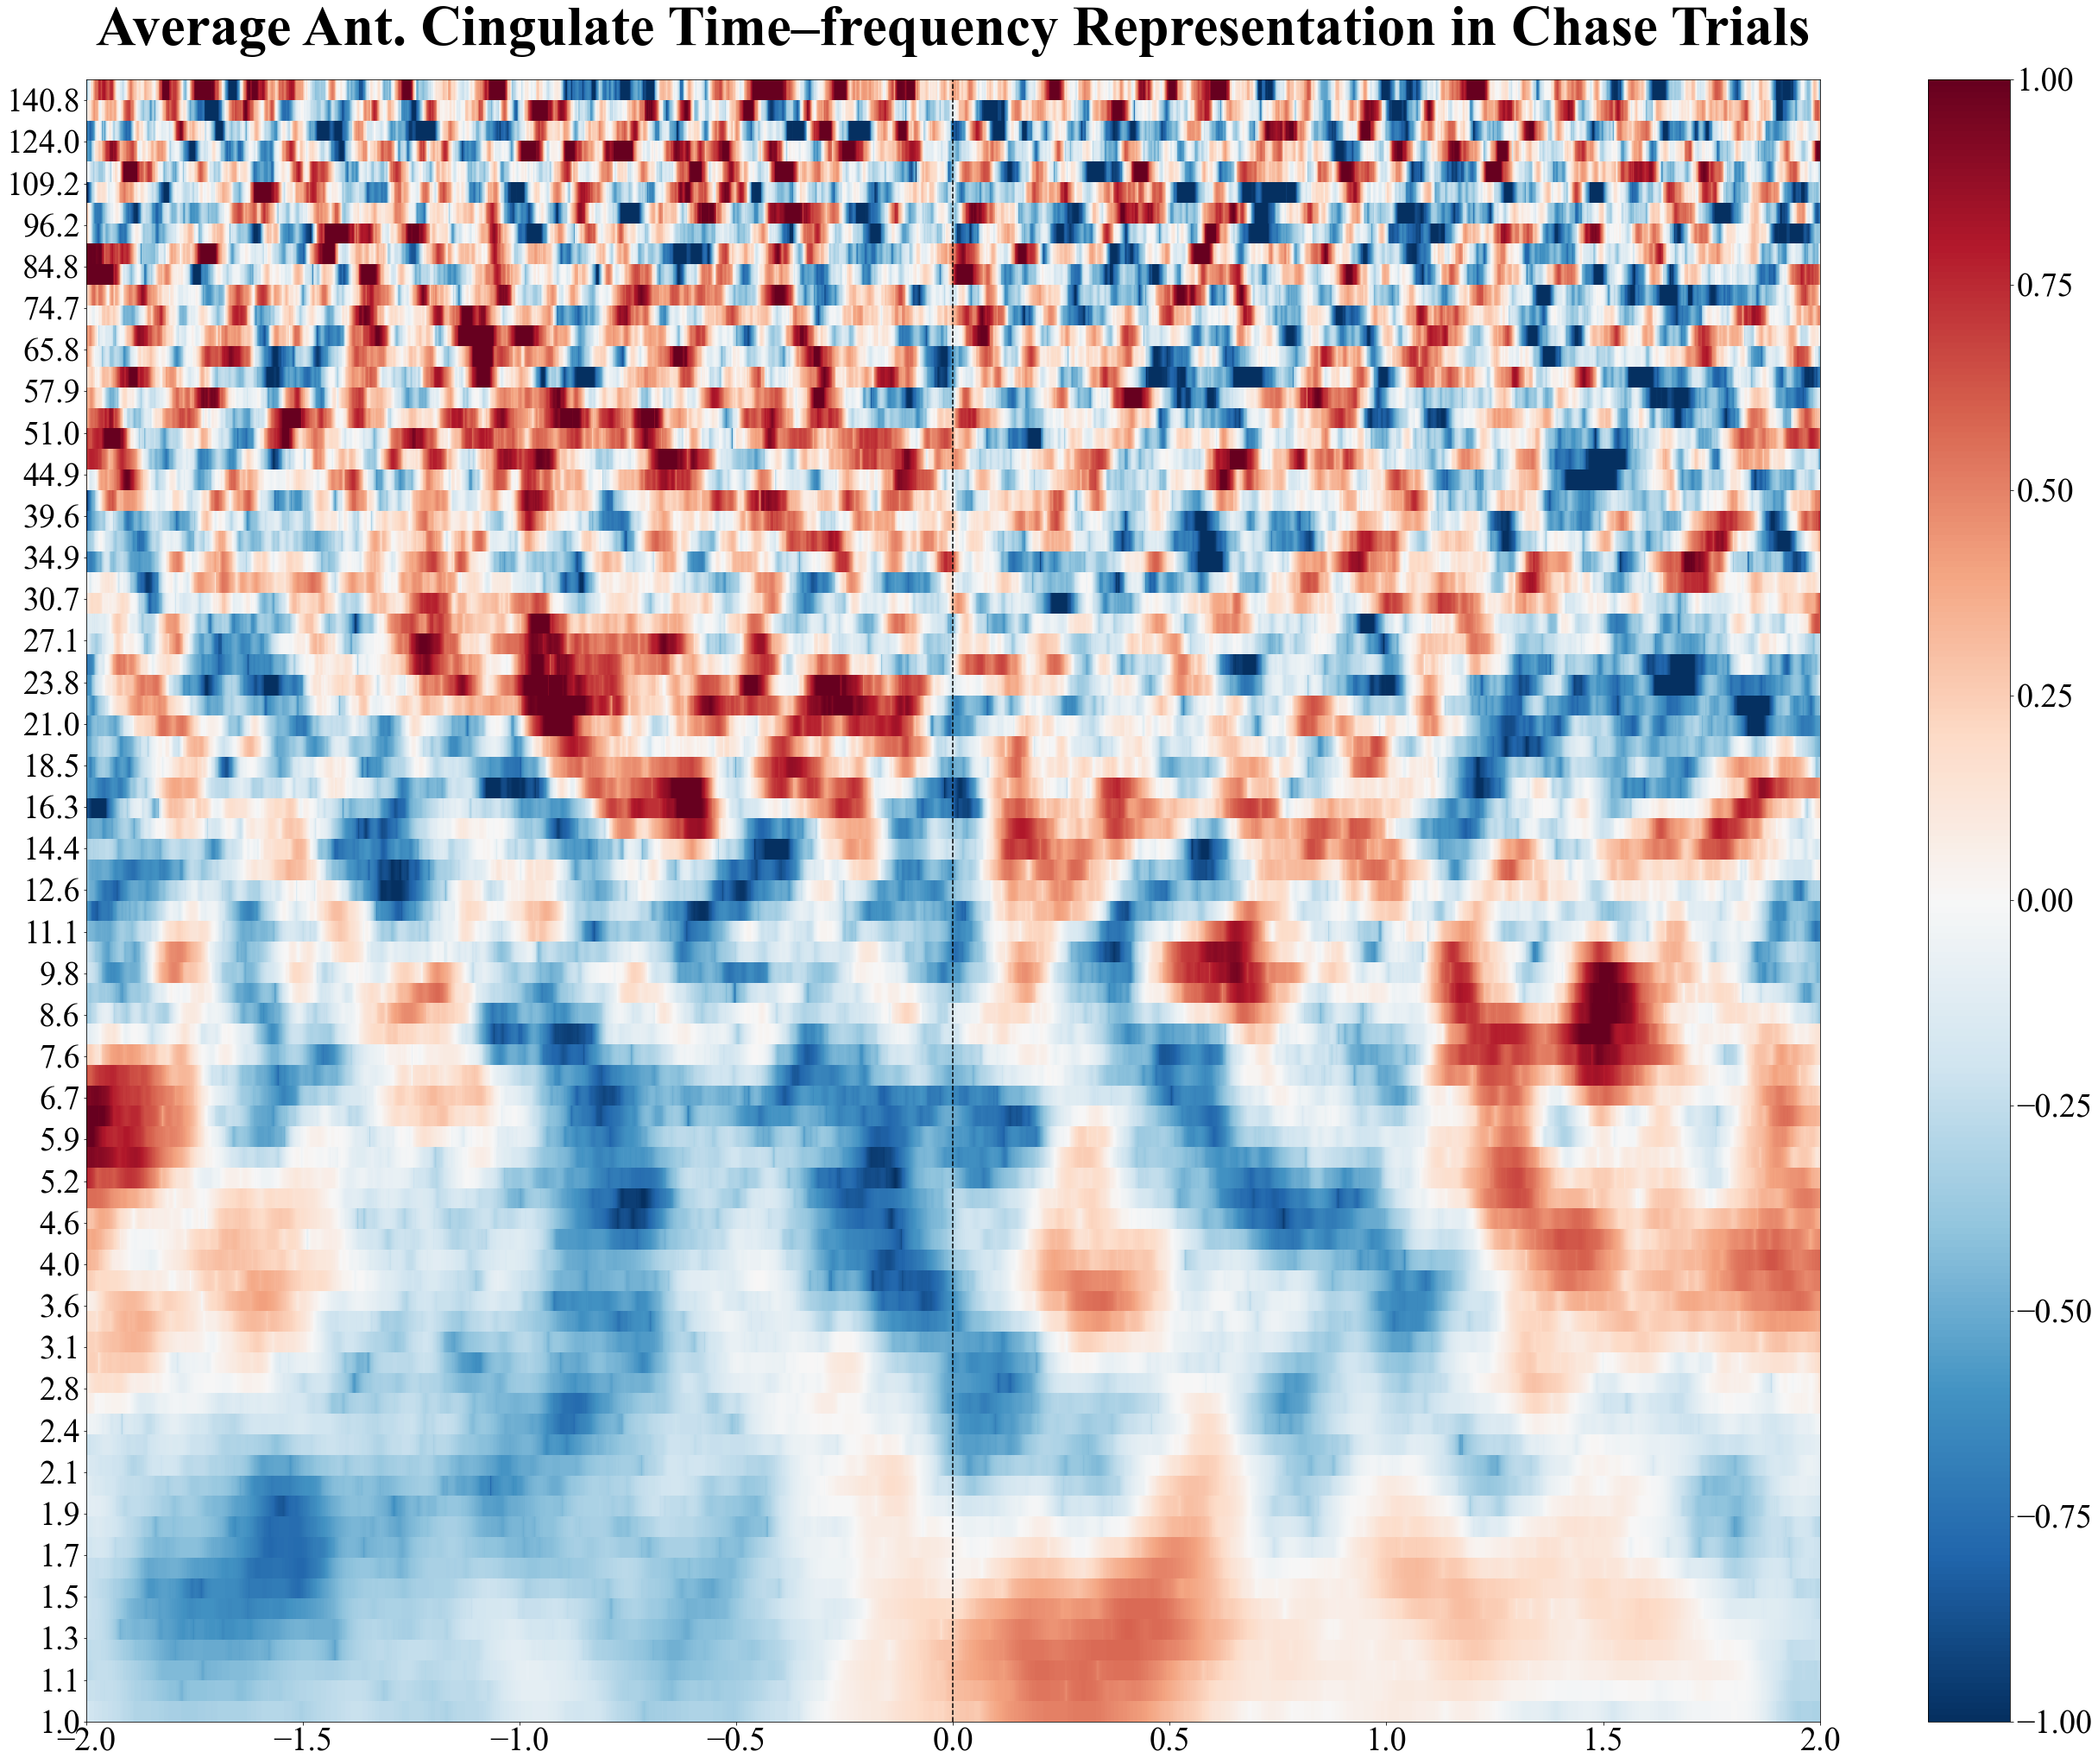

In [14]:
plot_allsub_averages(all_subs_average_cing_chase, "Average Ant. Cingulate Time–frequency Representation in Chase Trials", 'average_cing_chase_all_subs.png')

In [15]:
plot_allsub_averages(all_subs_average_cing_die, "Average Ant. Cingulate Time–frequency Representation in Death Trials", 'average_cing_death_all_subs.png')

## Amygdala

In [16]:
all_subs_average_amygs = calculate_trial_end_average(sub_list, conditions, 'amyg')
all_subs_average_amyg_escape = all_subs_average_amygs[0]
all_subs_average_amyg_chase = all_subs_average_amygs[1]
all_subs_average_amyg_die = all_subs_average_amygs[2]

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/trial_end/amyg-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/trial_end/amyg-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/trial_end/amyg-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/trial_end/amyg-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/trial_end/a

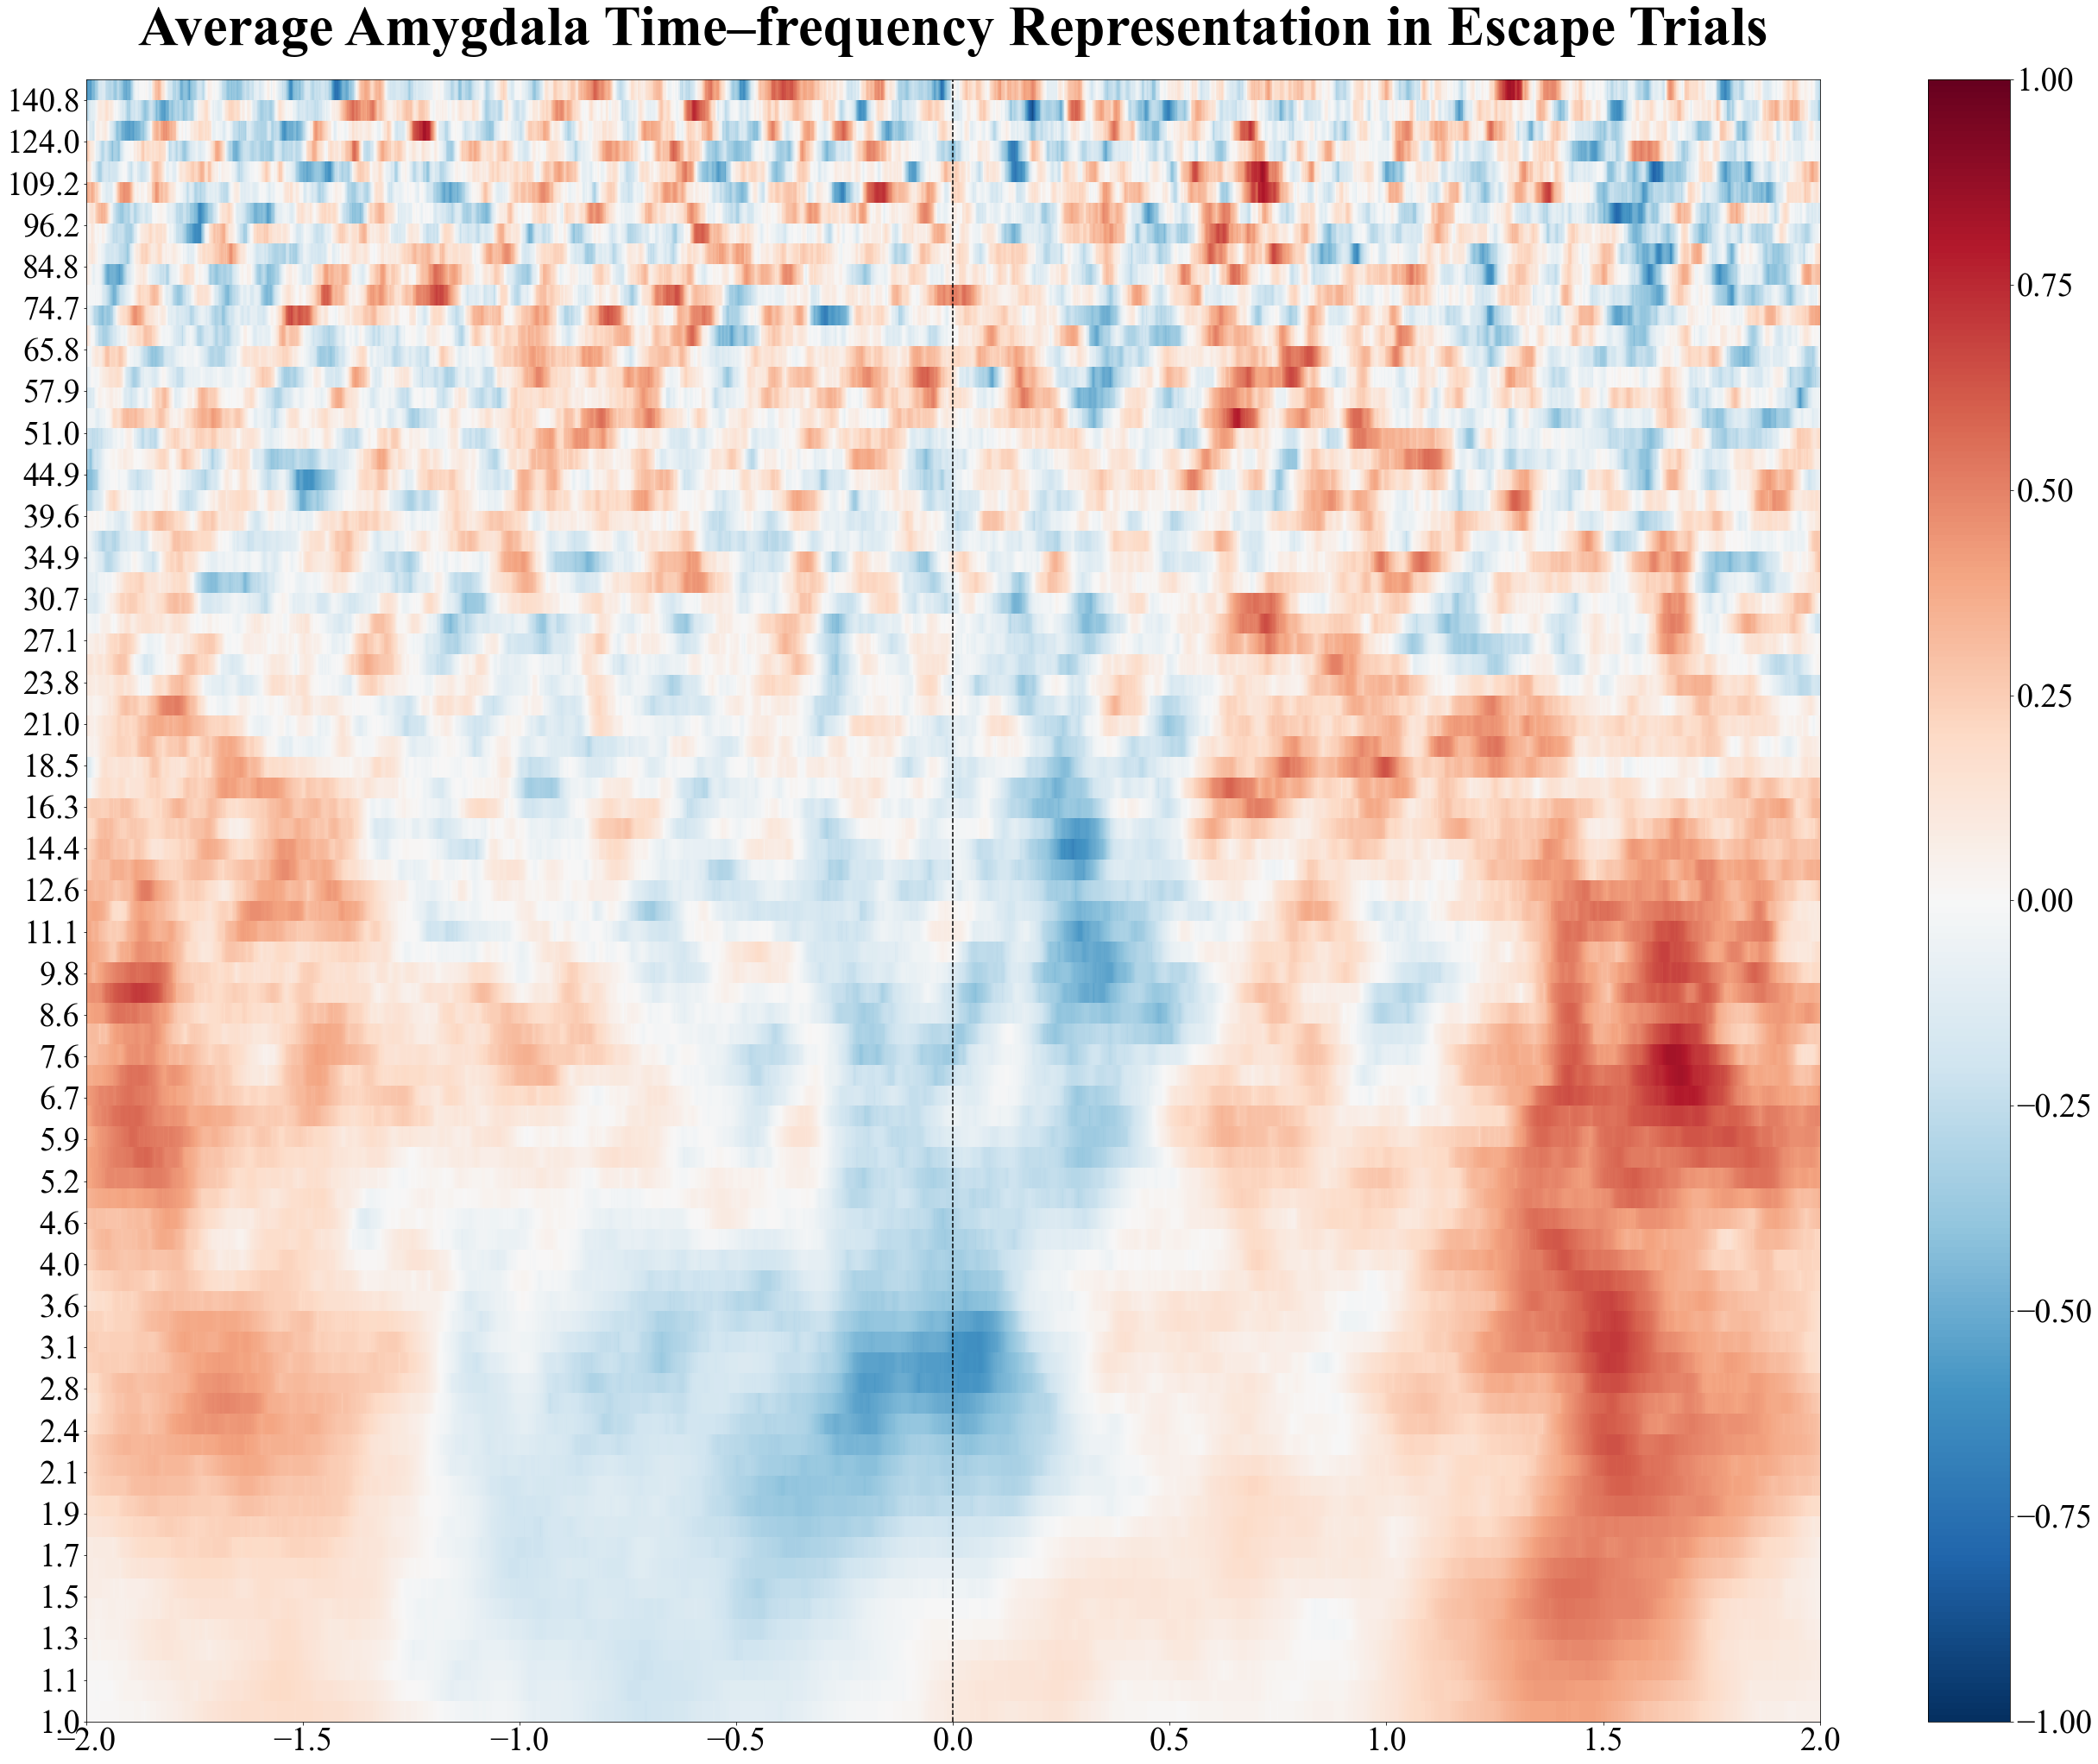

In [17]:
plot_allsub_averages(all_subs_average_amyg_escape, "Average Amygdala Time–frequency Representation in Escape Trials", 'average_amyg_escape_all_subs.png')

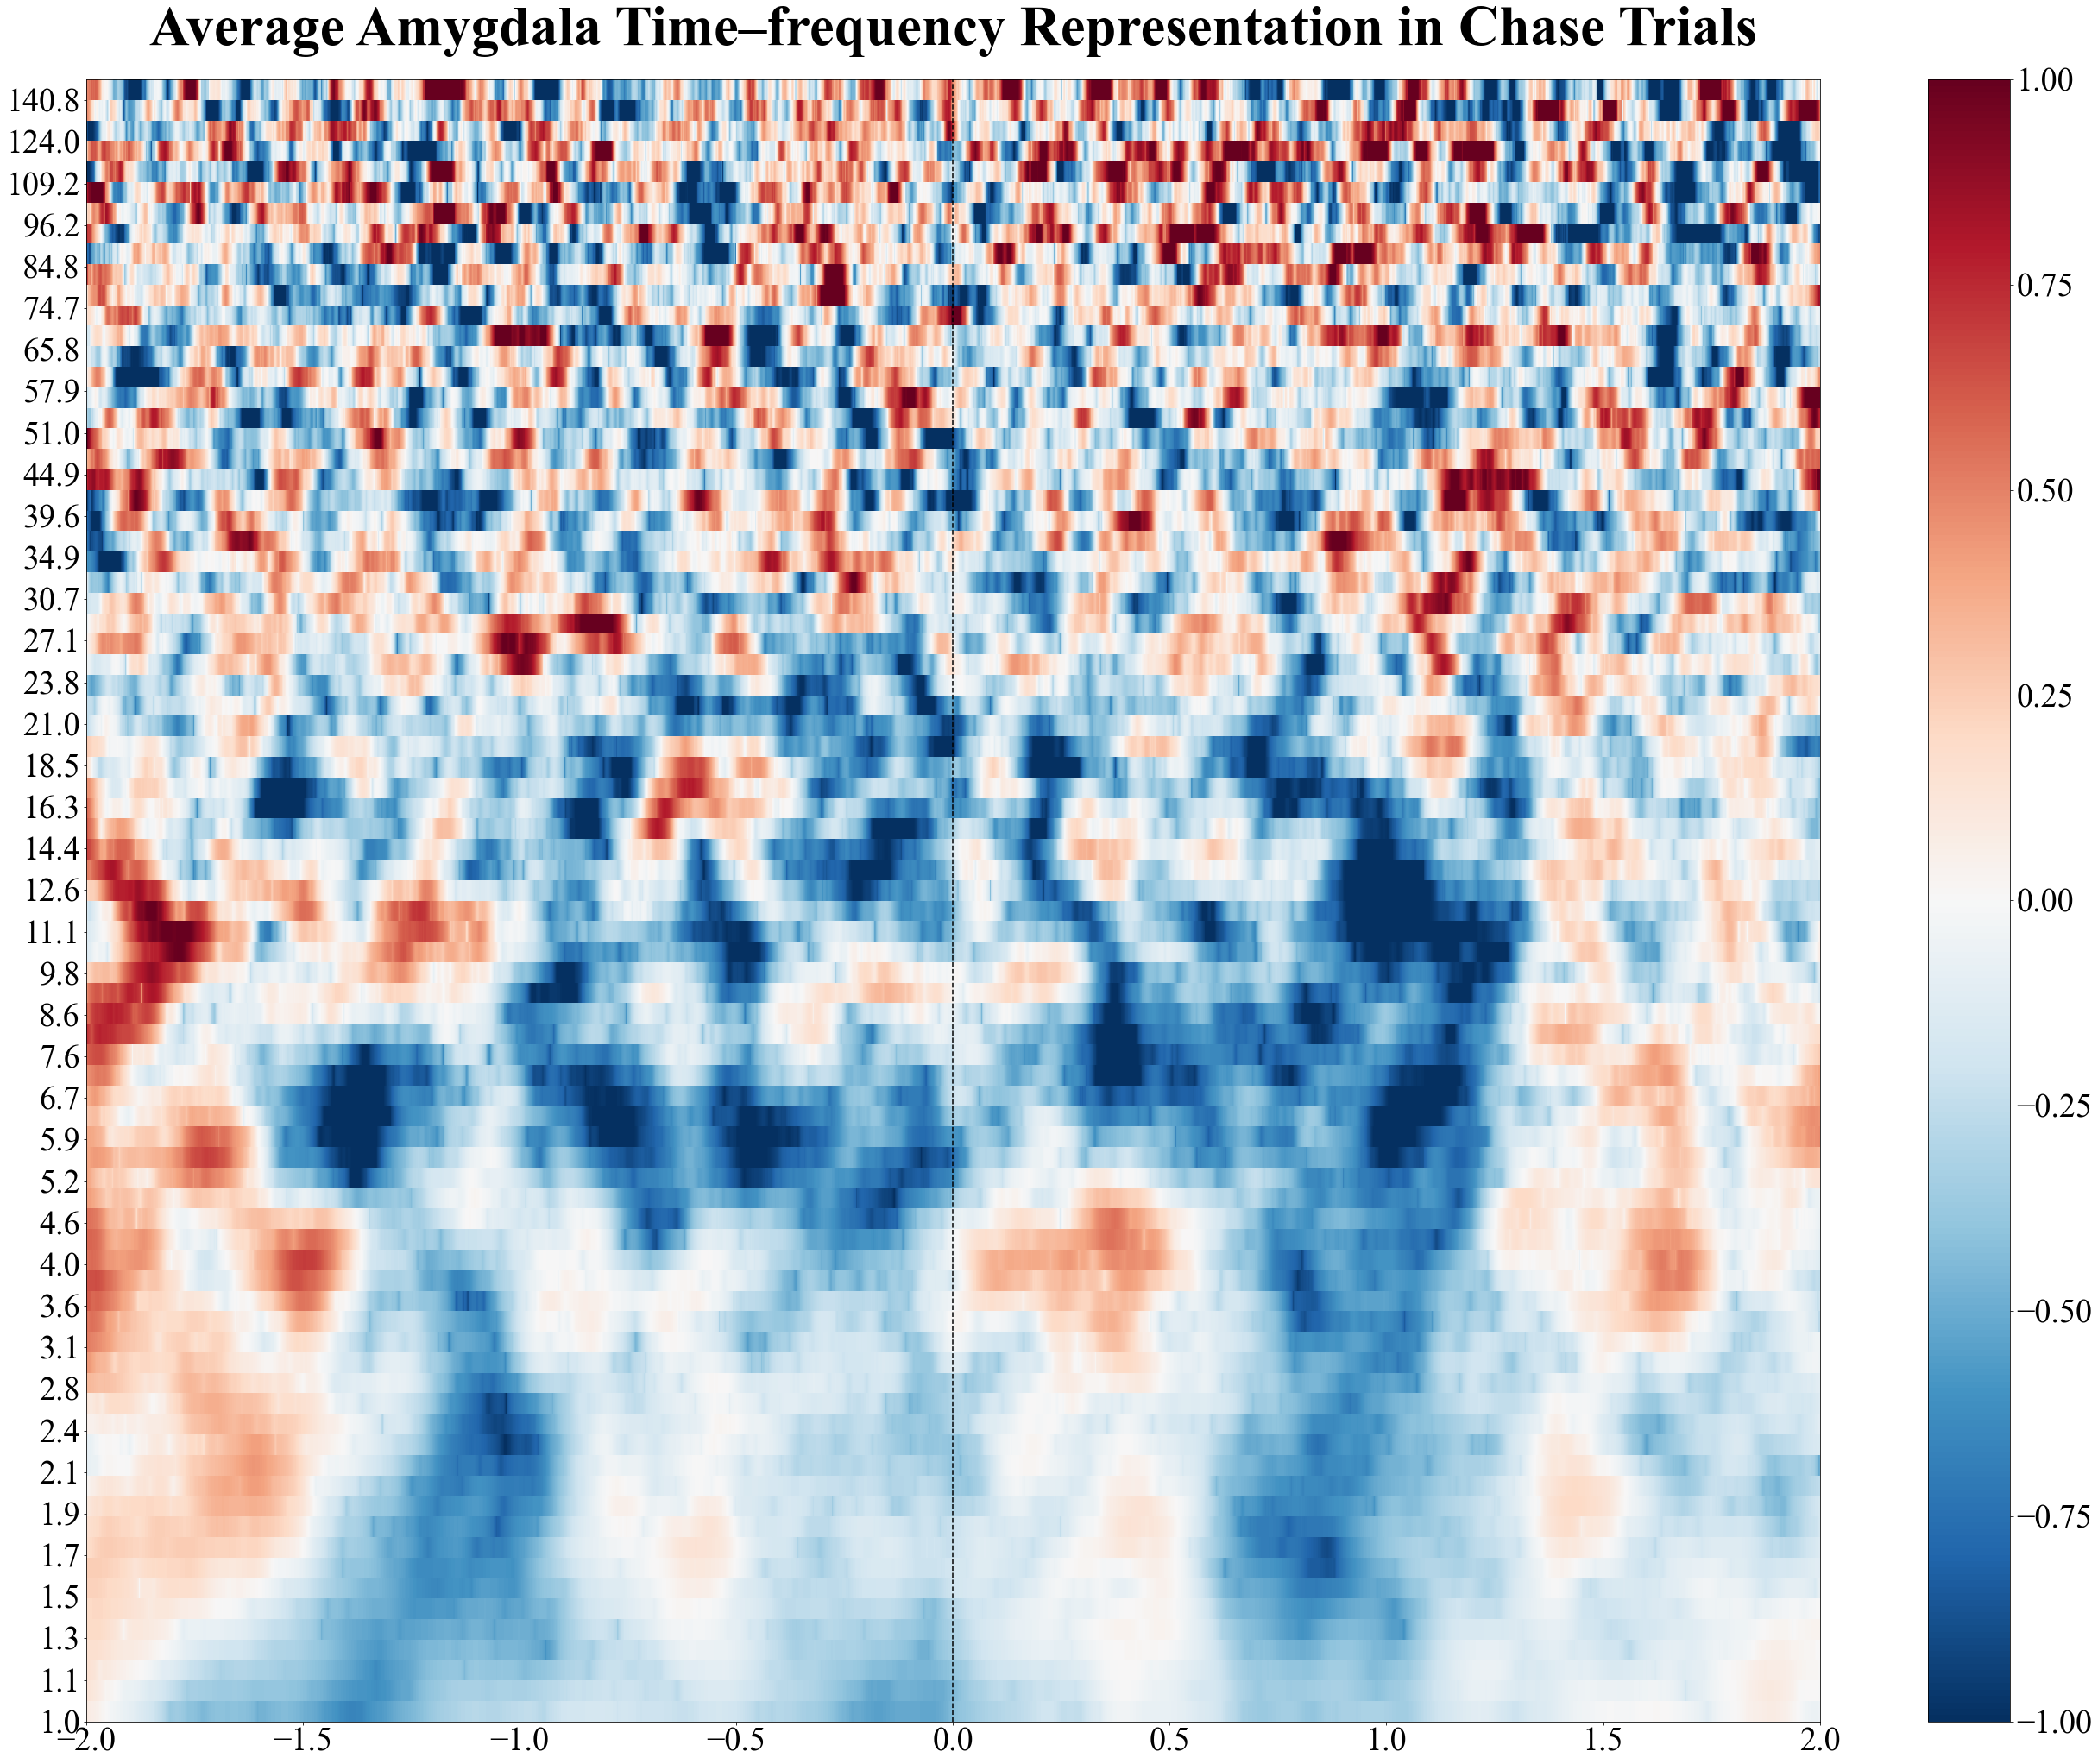

In [18]:
plot_allsub_averages(all_subs_average_amyg_chase, "Average Amygdala Time–frequency Representation in Chase Trials", 'average_amyg_chase_all_subs.png')

In [2]:
plot_allsub_averages(all_subs_average_amyg_die, "Average Amygdala Time–frequency Representation in Death Trials", 'average_amyg_death_all_subs.png')

# Other Regions

## dlPFC

In [20]:
all_subs_average_dlpfcs = calculate_trial_end_average(sub_list, conditions, 'dlpfc')
all_subs_average_dlpfc_escape = all_subs_average_dlpfcs[0]
all_subs_average_dlpfc_chase = all_subs_average_dlpfcs[1]
all_subs_average_dlpfc_die = all_subs_average_dlpfcs[2]

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/trial_end/dlpfc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/trial_end/dlpfc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/trial_end/dlpfc-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/trial_end/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/trial_e

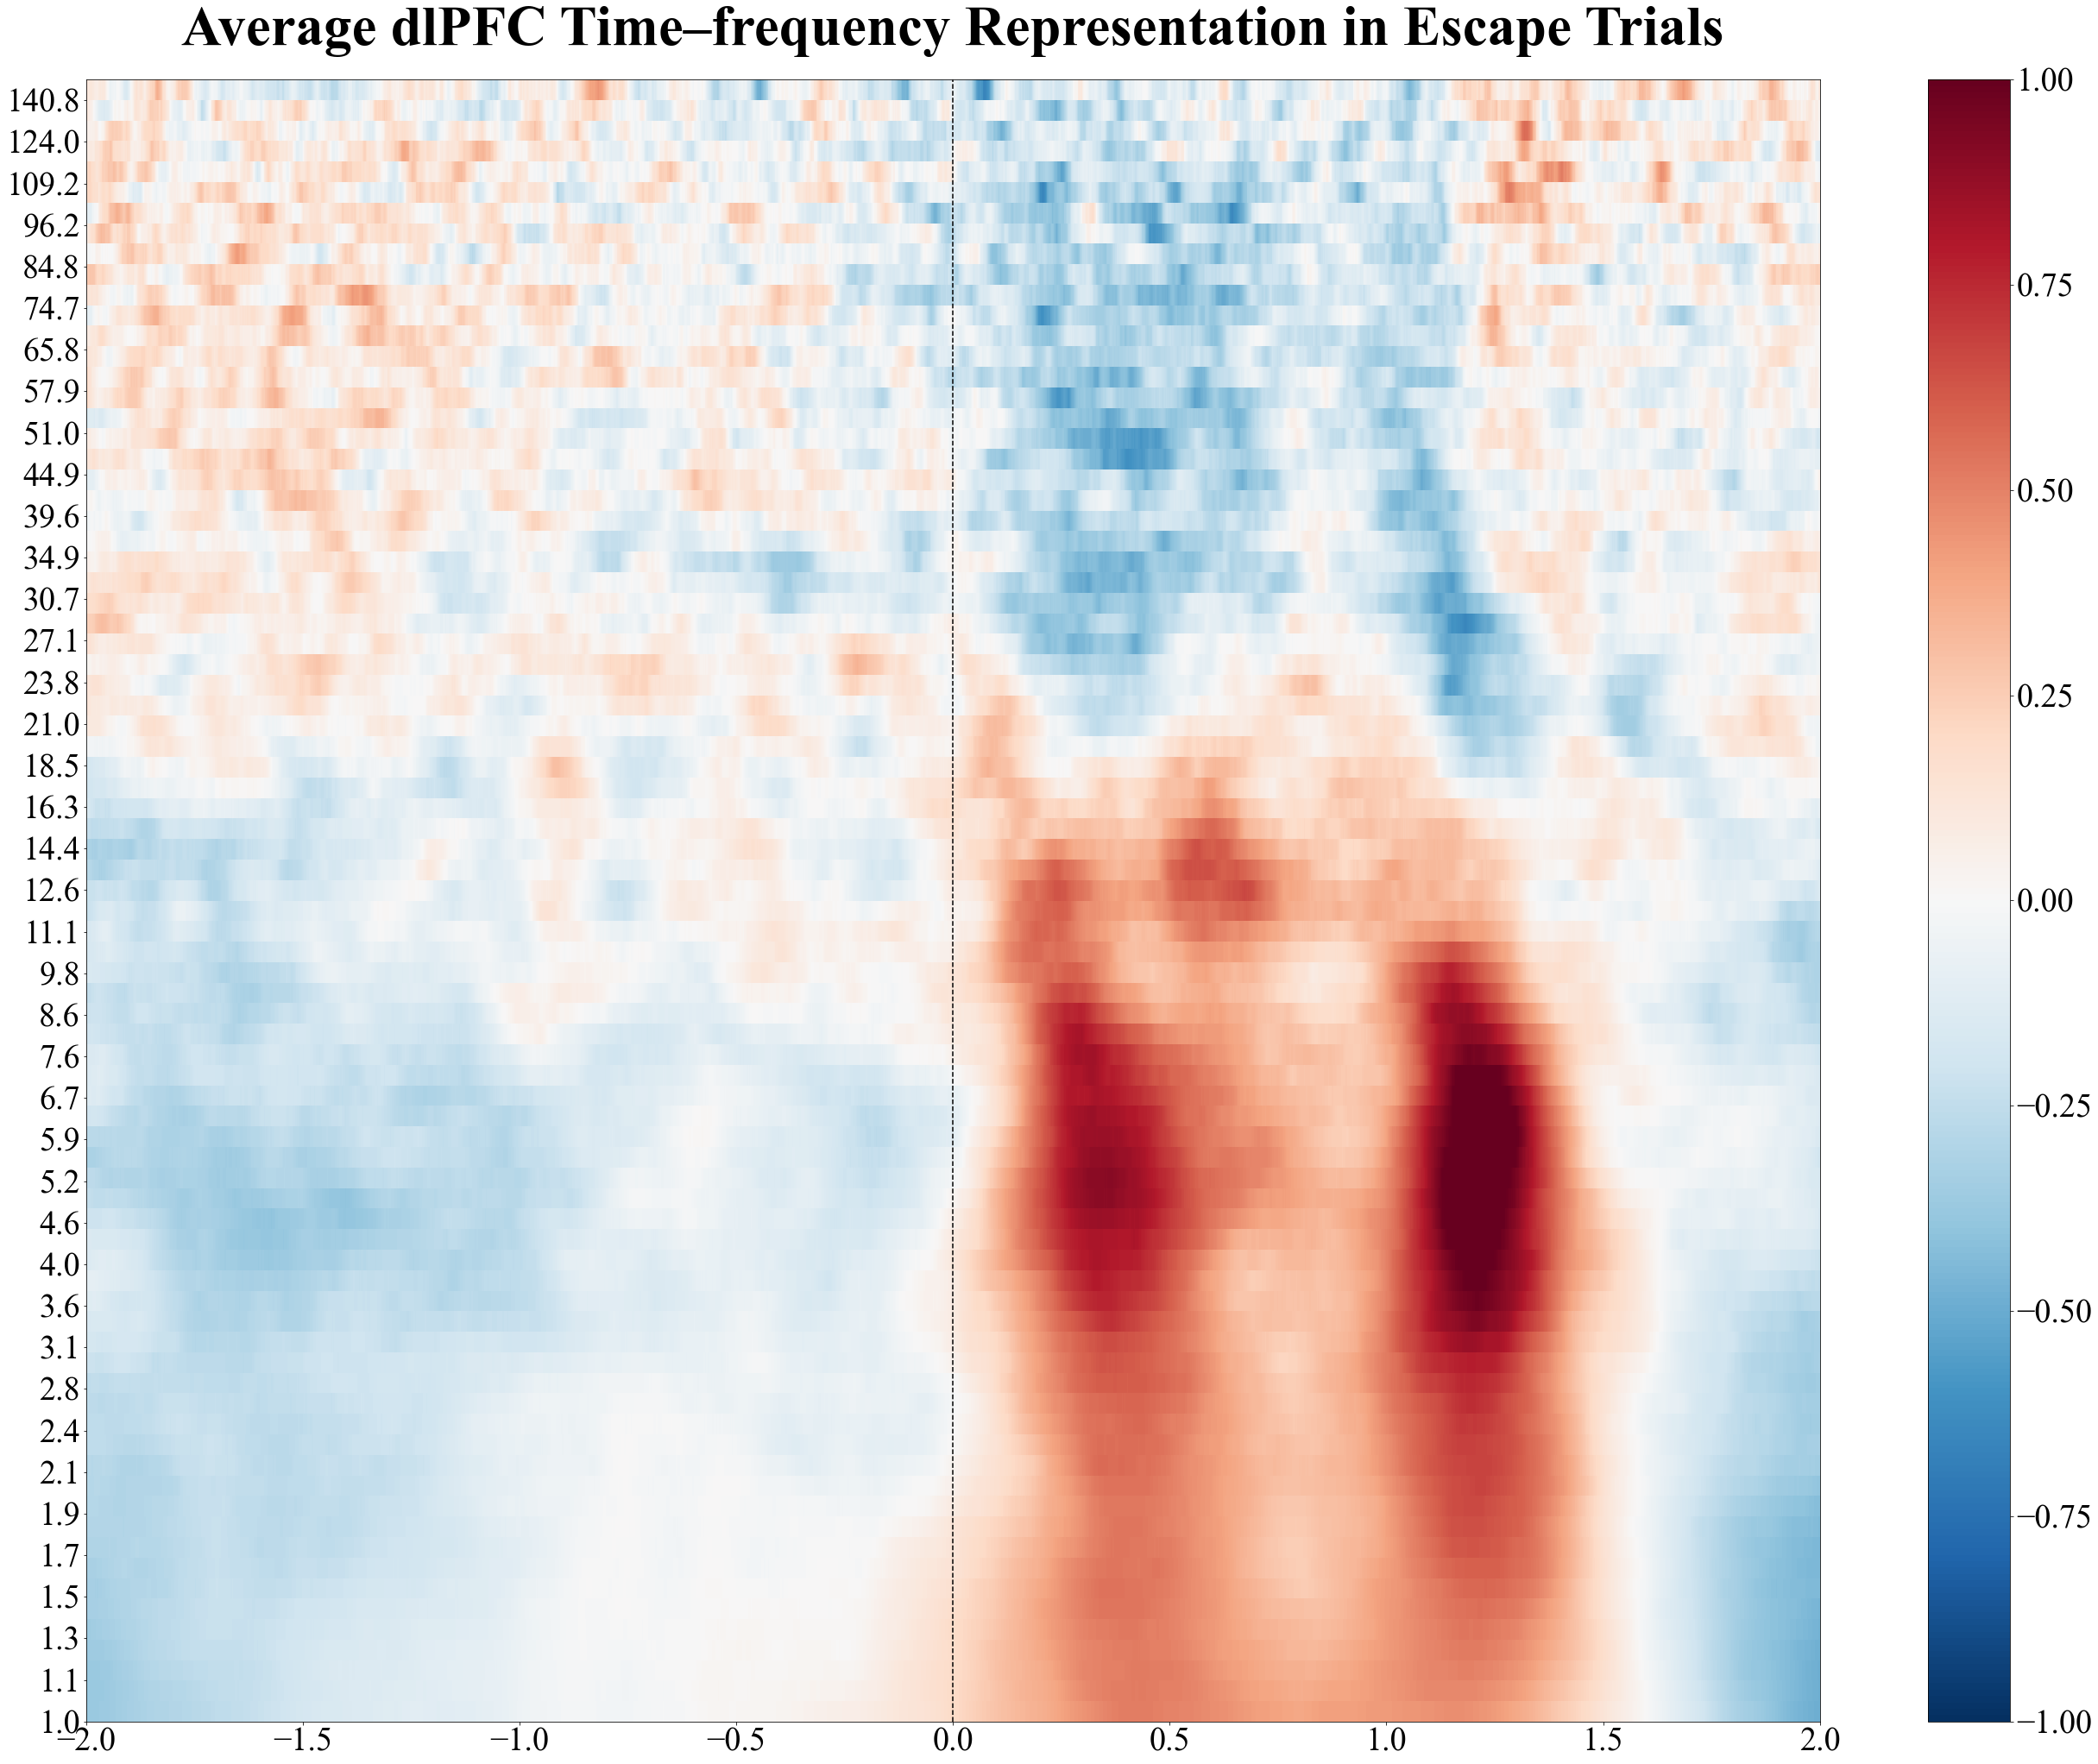

In [21]:
plot_allsub_averages(all_subs_average_dlpfc_escape, "Average dlPFC Time–frequency Representation in Escape Trials", 'average_dlpfc_escape_all_subs.png')

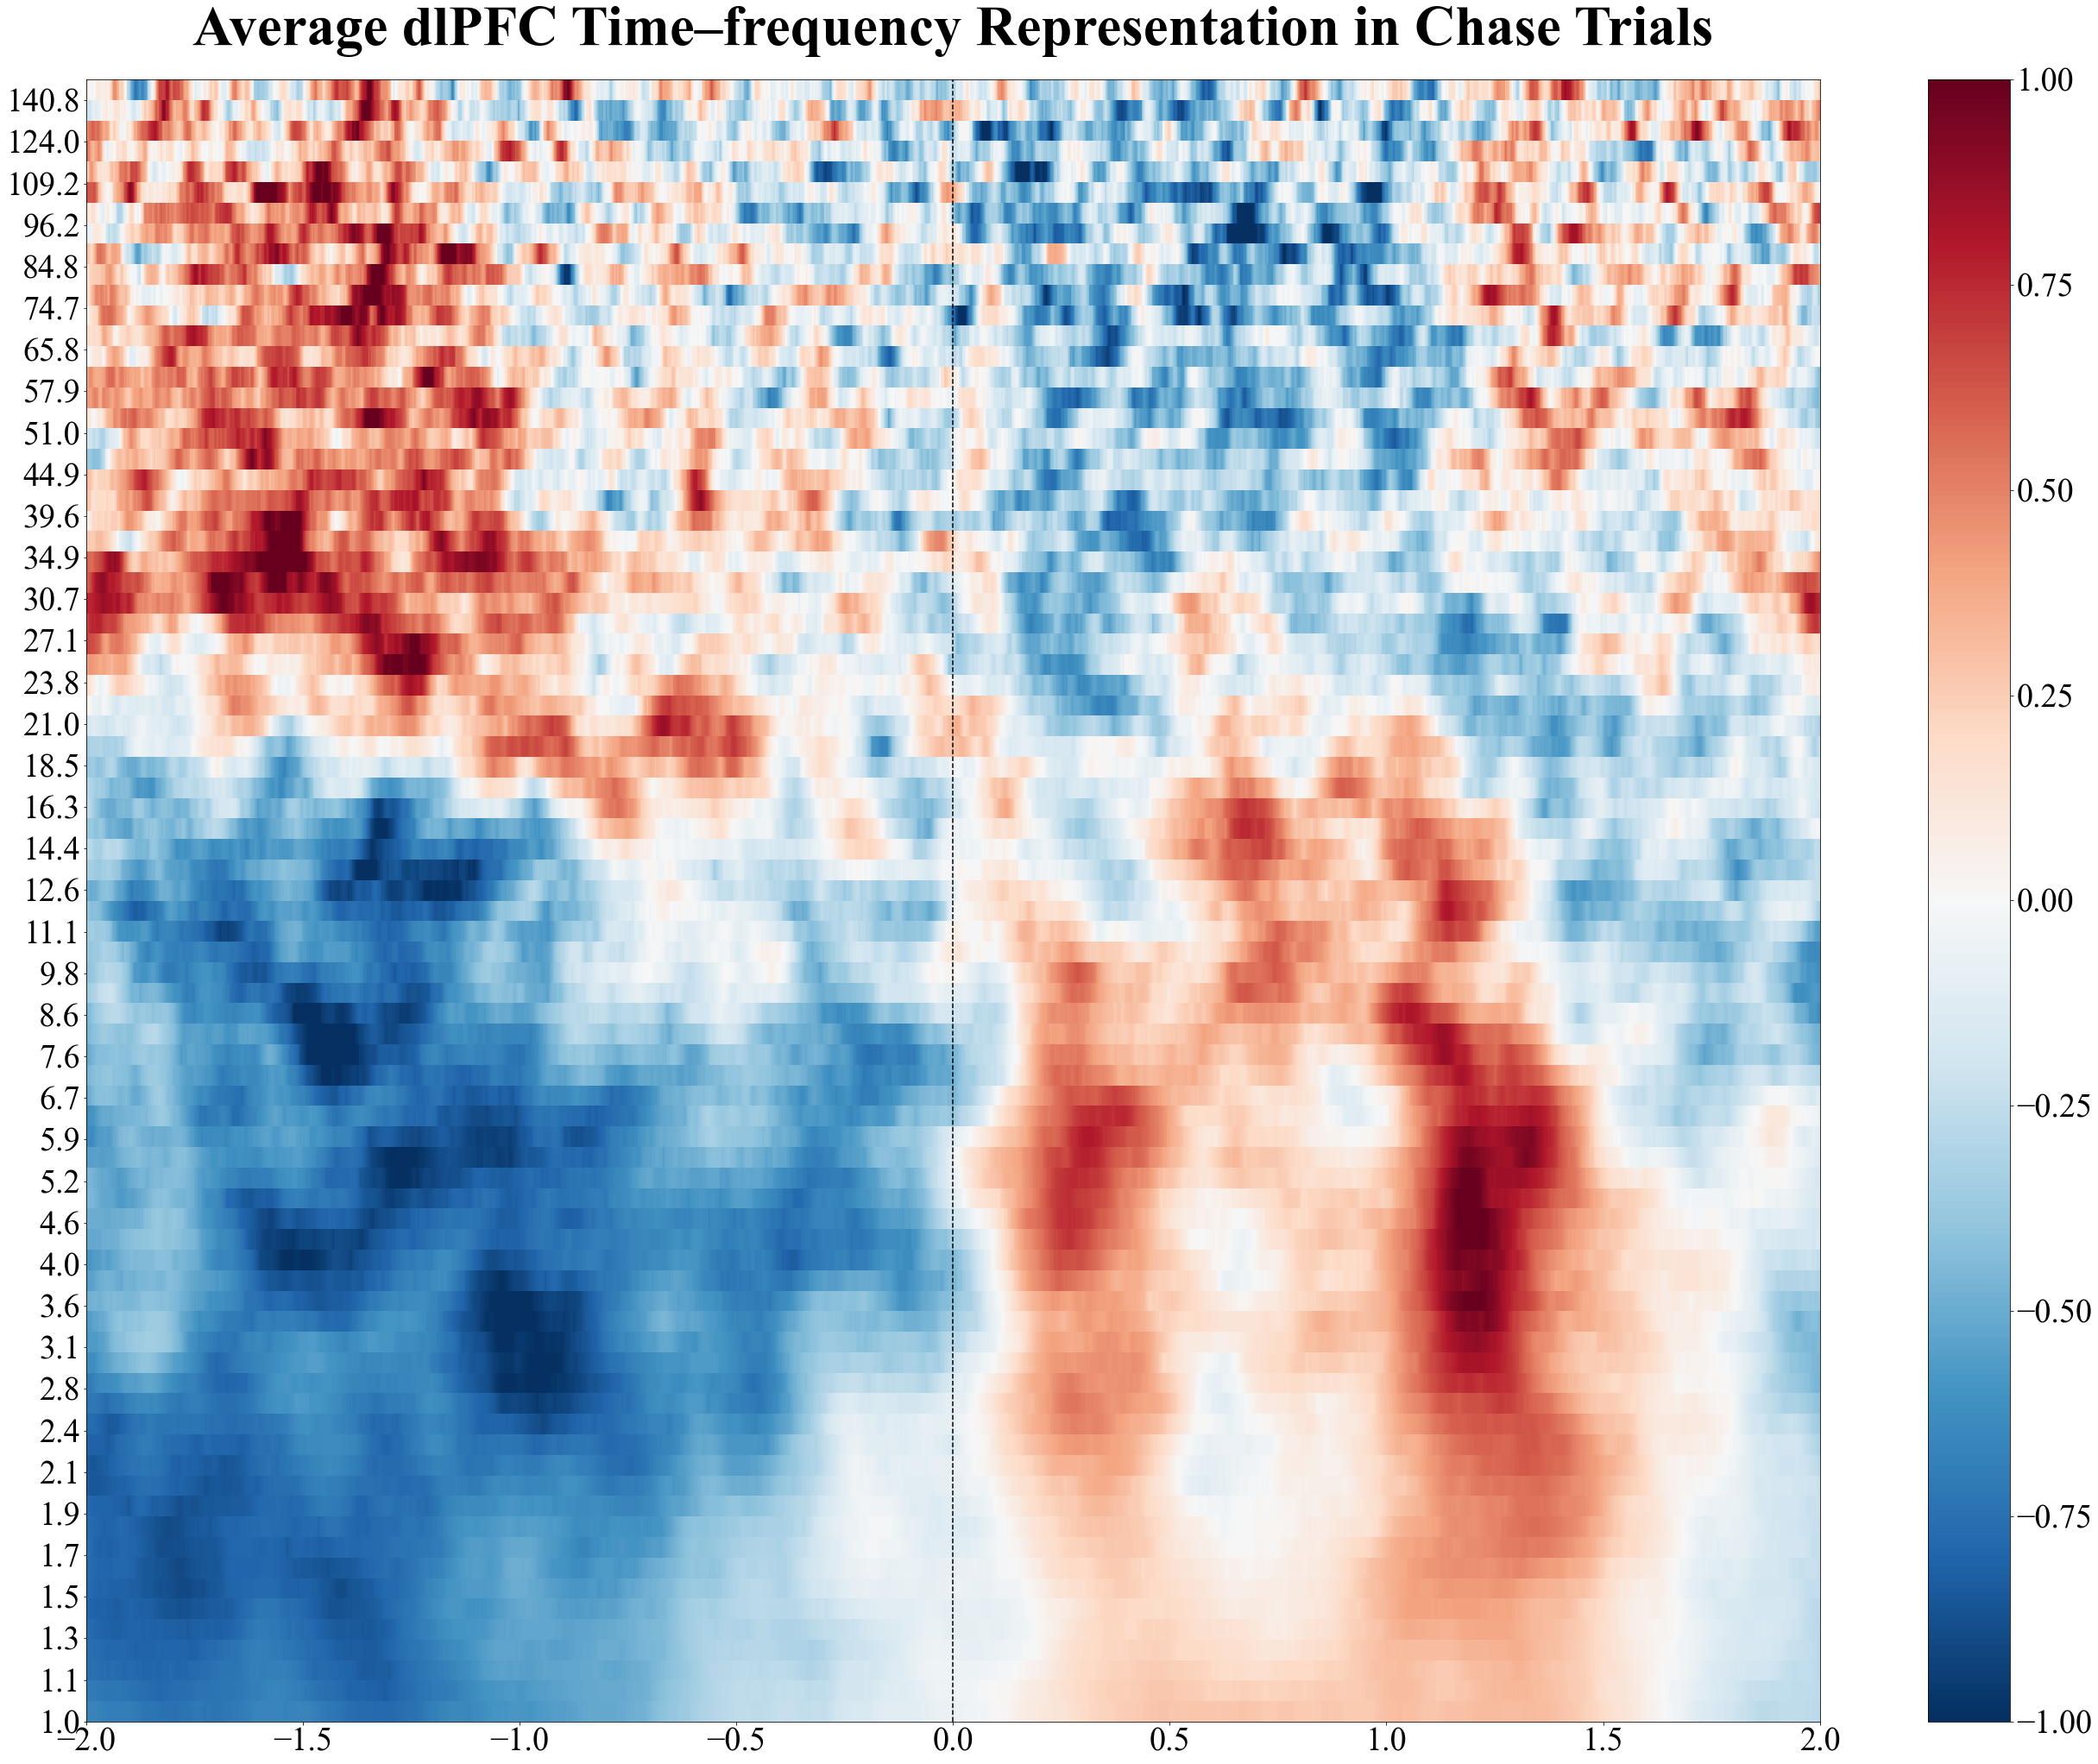

In [22]:
plot_allsub_averages(all_subs_average_dlpfc_chase, "Average dlPFC Time–frequency Representation in Chase Trials", 'average_dlpfc_chase_all_subs.png')

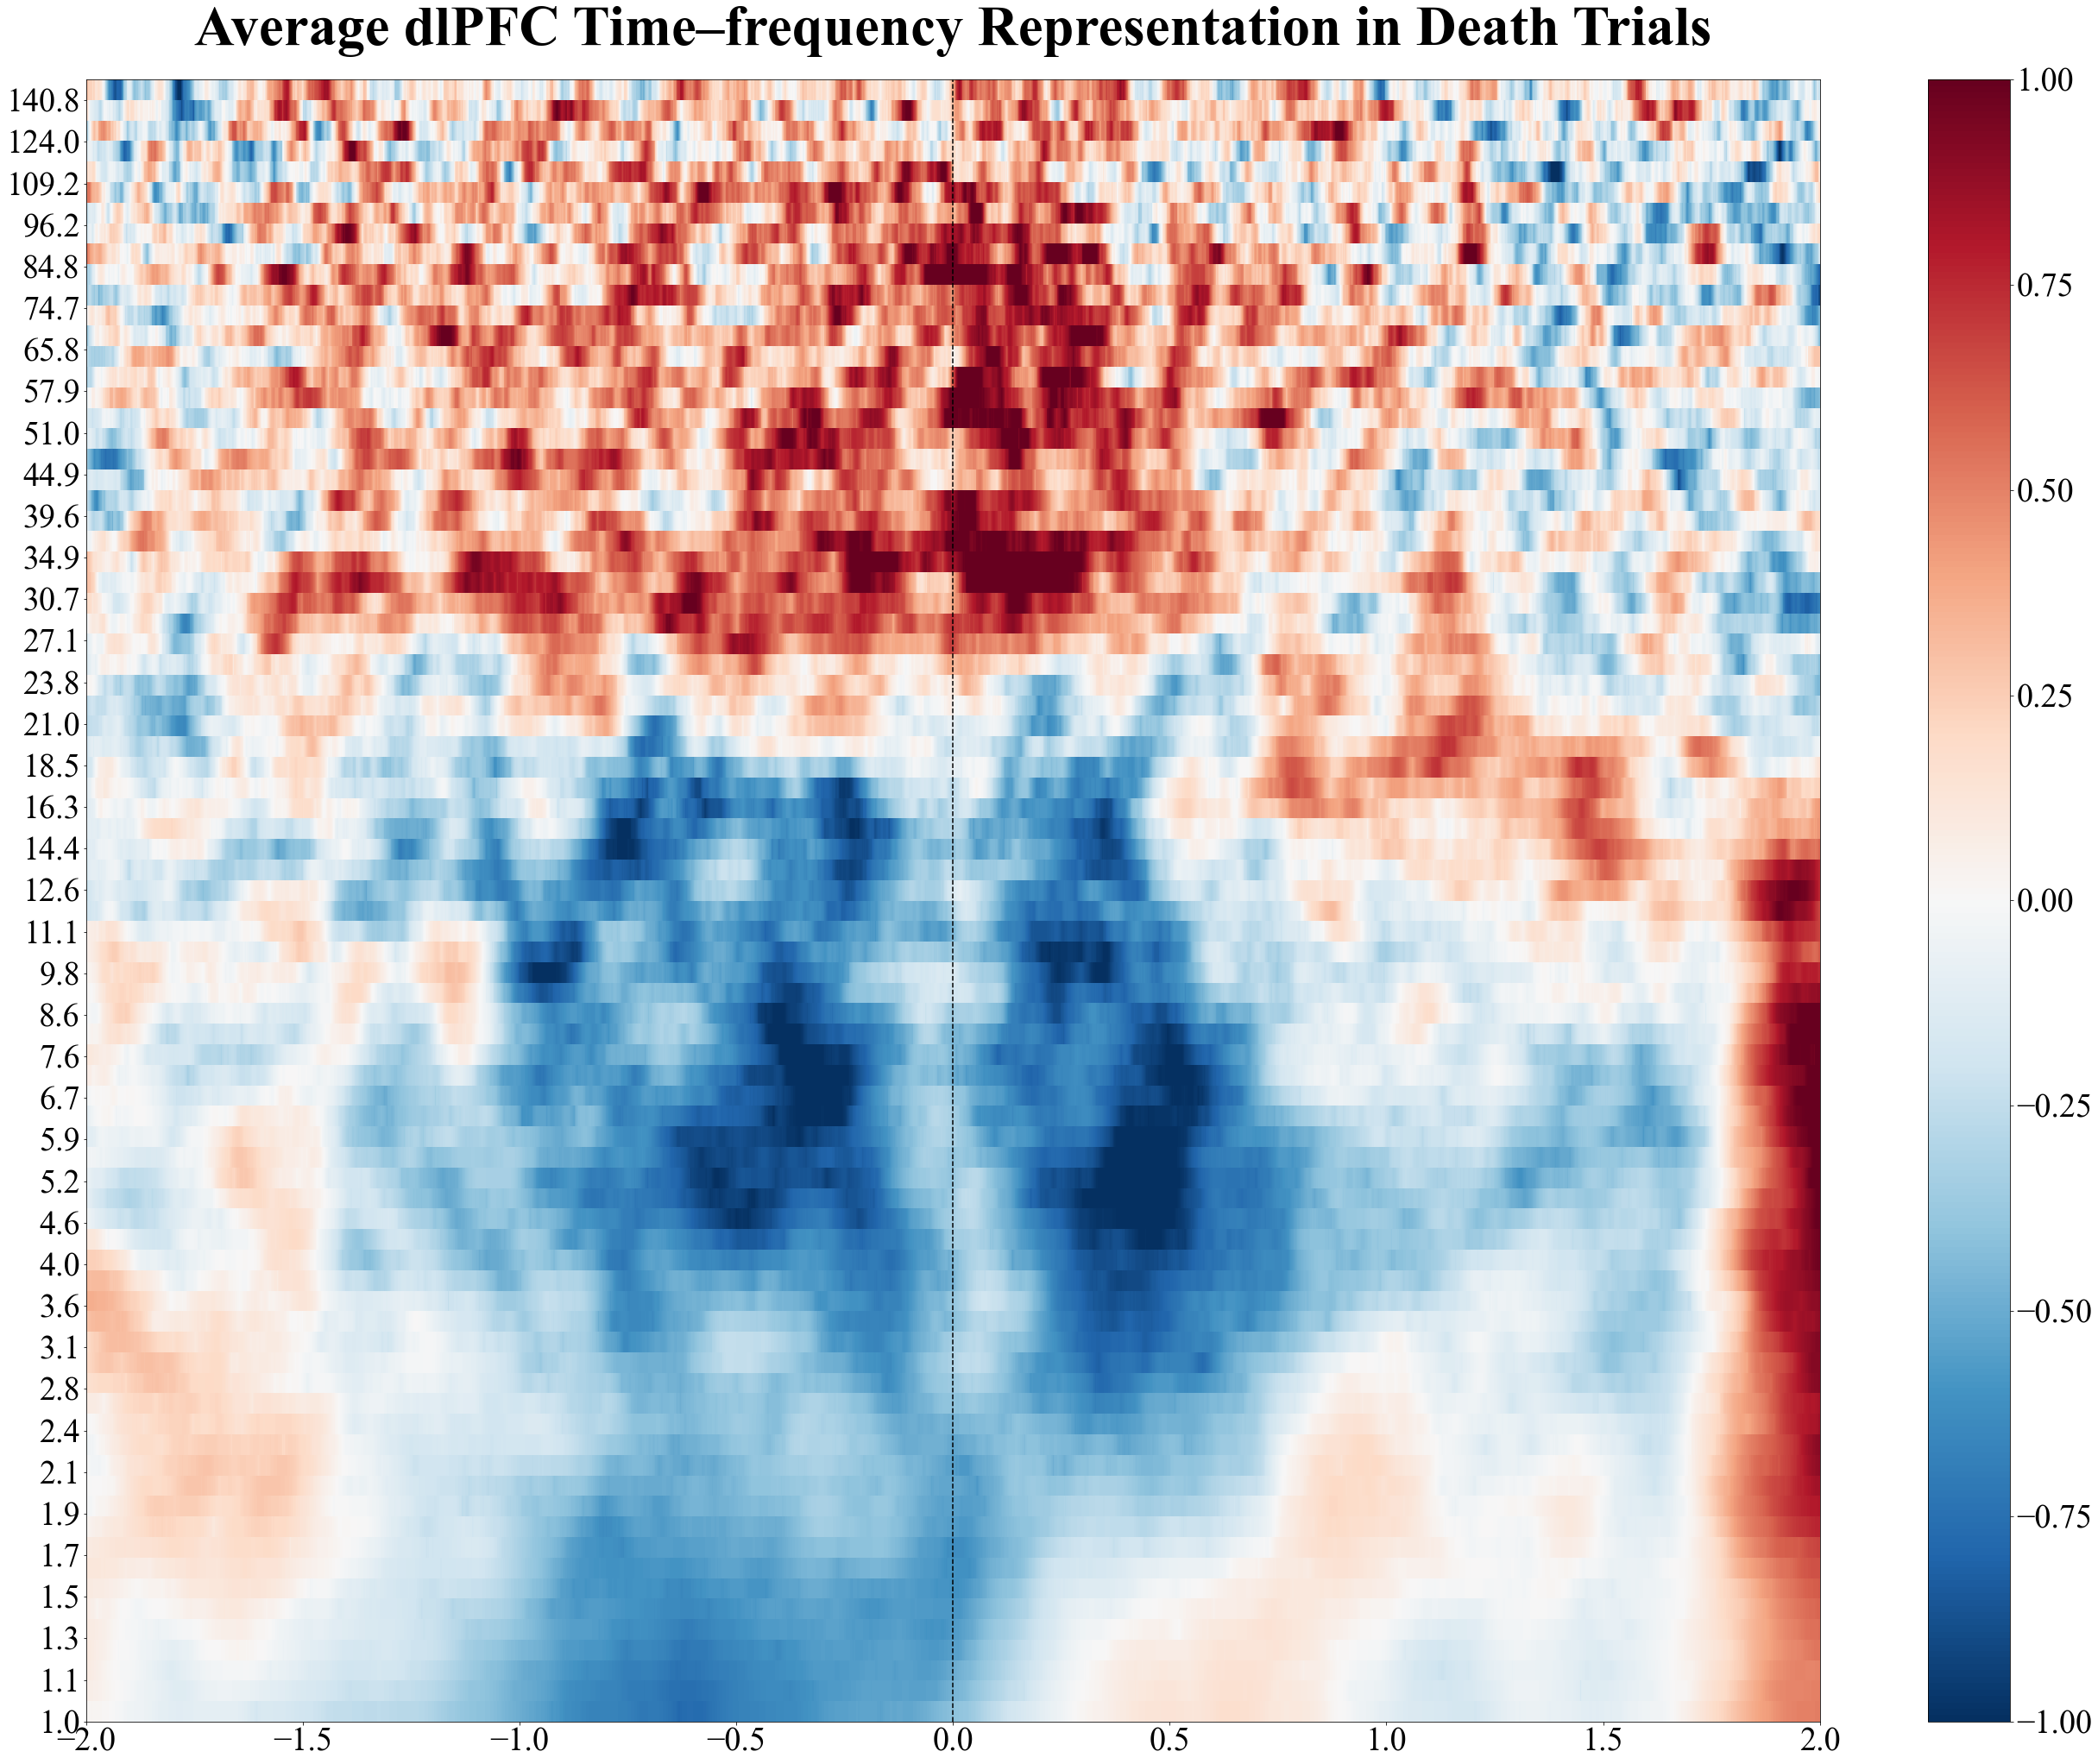

In [23]:
plot_allsub_averages(all_subs_average_dlpfc_die, "Average dlPFC Time–frequency Representation in Death Trials", 'average_dlpfc_death_all_subs.png')

## Insula

In [24]:
all_subs_average_insulas = calculate_trial_end_average(sub_list, conditions, 'insula')
all_subs_average_insula_escape = all_subs_average_insulas[0]
all_subs_average_insula_chase = all_subs_average_insulas[1]
all_subs_average_insula_die = all_subs_average_insulas[2]

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/trial_end/insula-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/trial_end/insula-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/trial_end/insula-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/trial_end/insula-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/tri

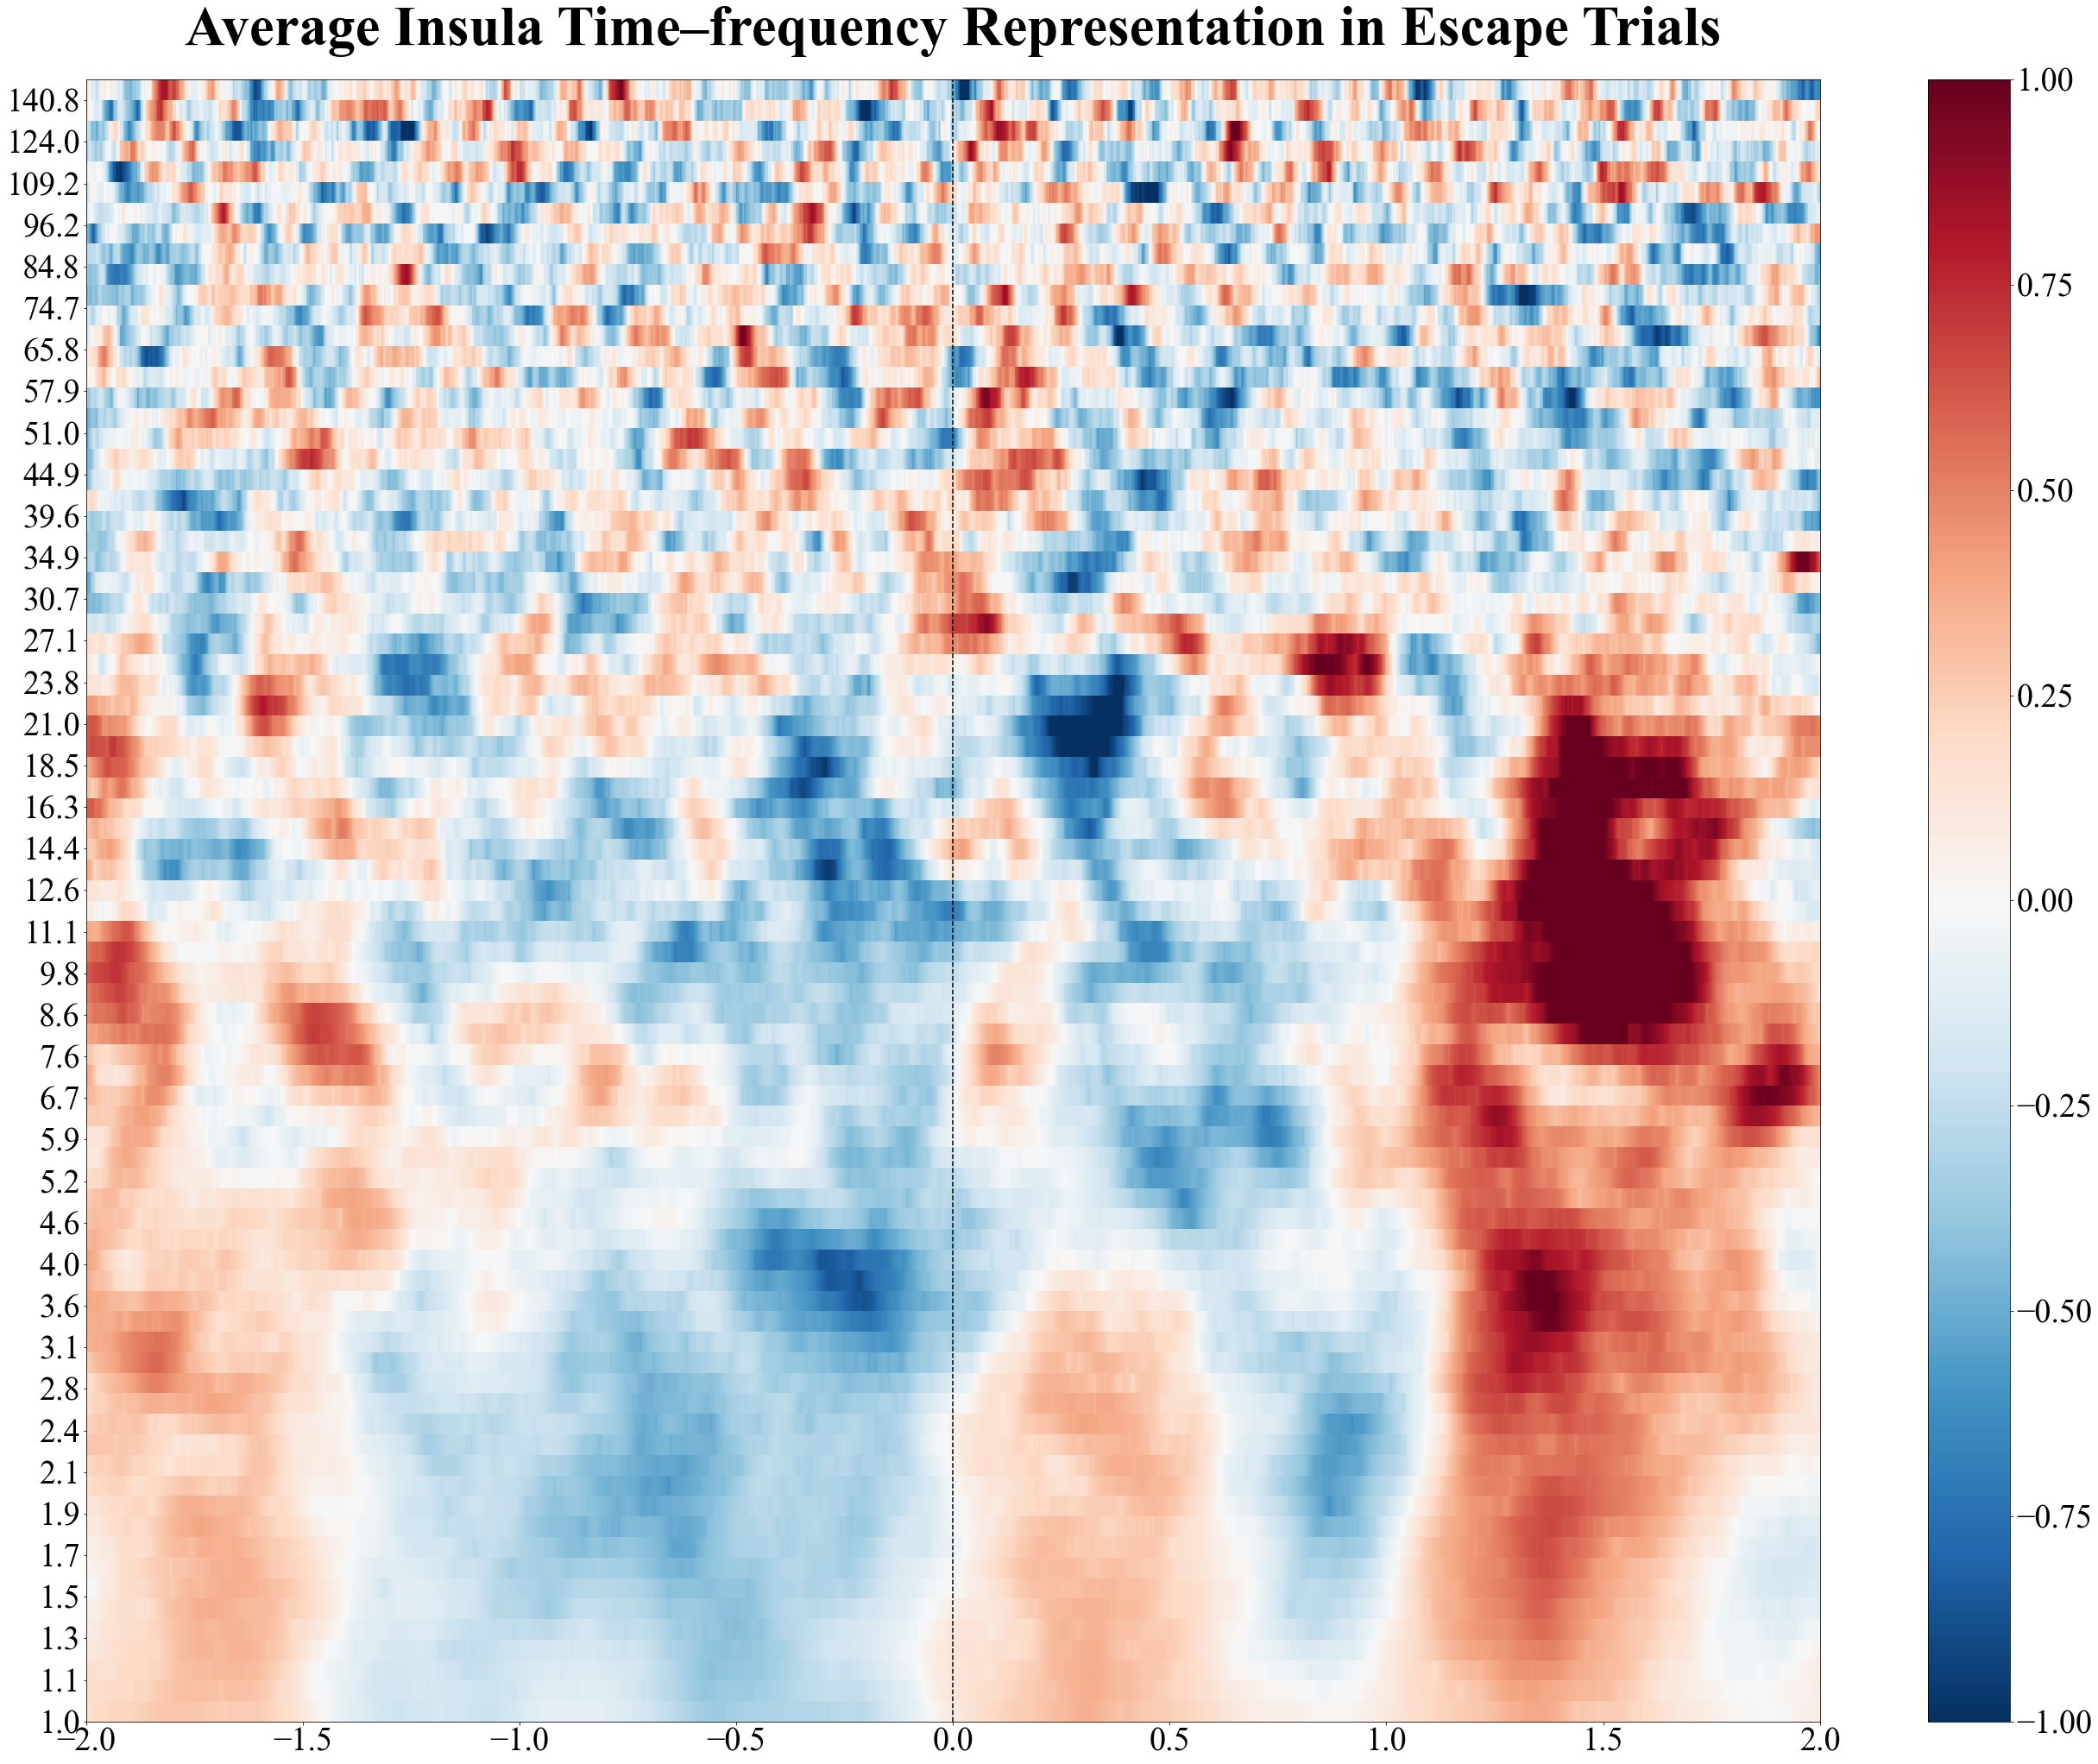

In [25]:
plot_allsub_averages(all_subs_average_insula_escape, "Average Insula Time–frequency Representation in Escape Trials", 'average_insula_escape_all_subs.png')

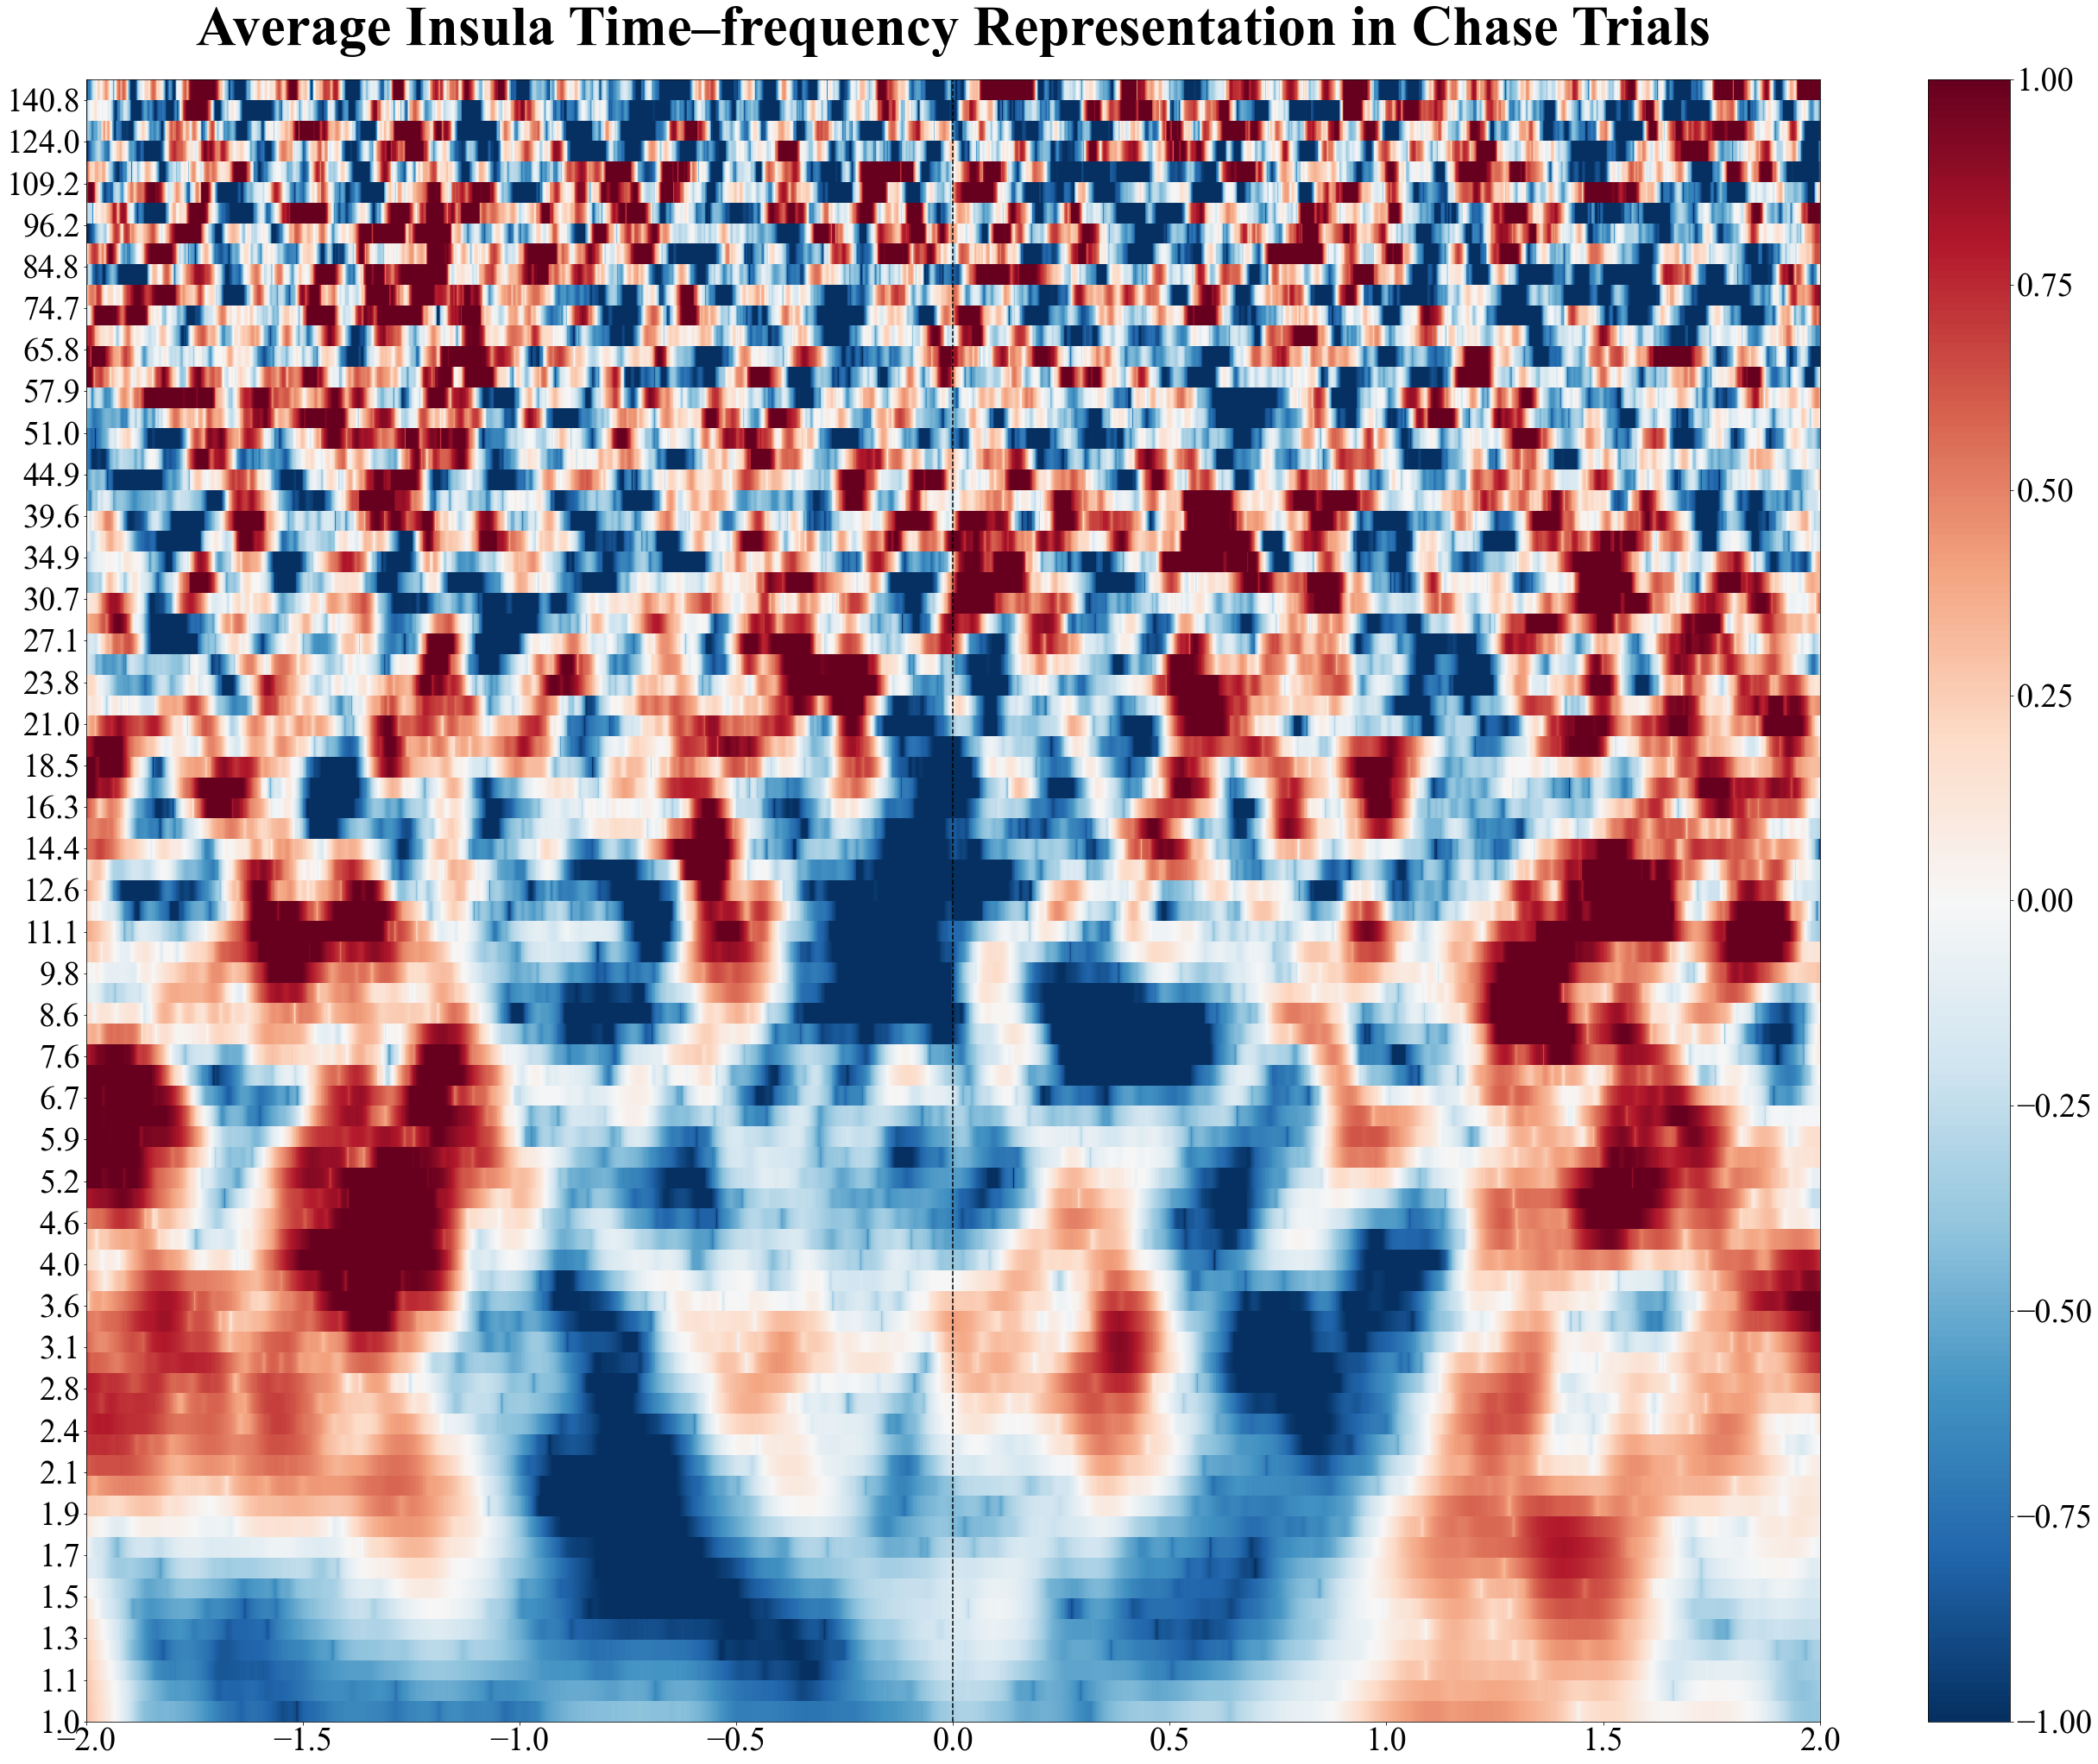

In [26]:
plot_allsub_averages(all_subs_average_insula_chase, "Average Insula Time–frequency Representation in Chase Trials", 'average_insula_chase_all_subs.png')

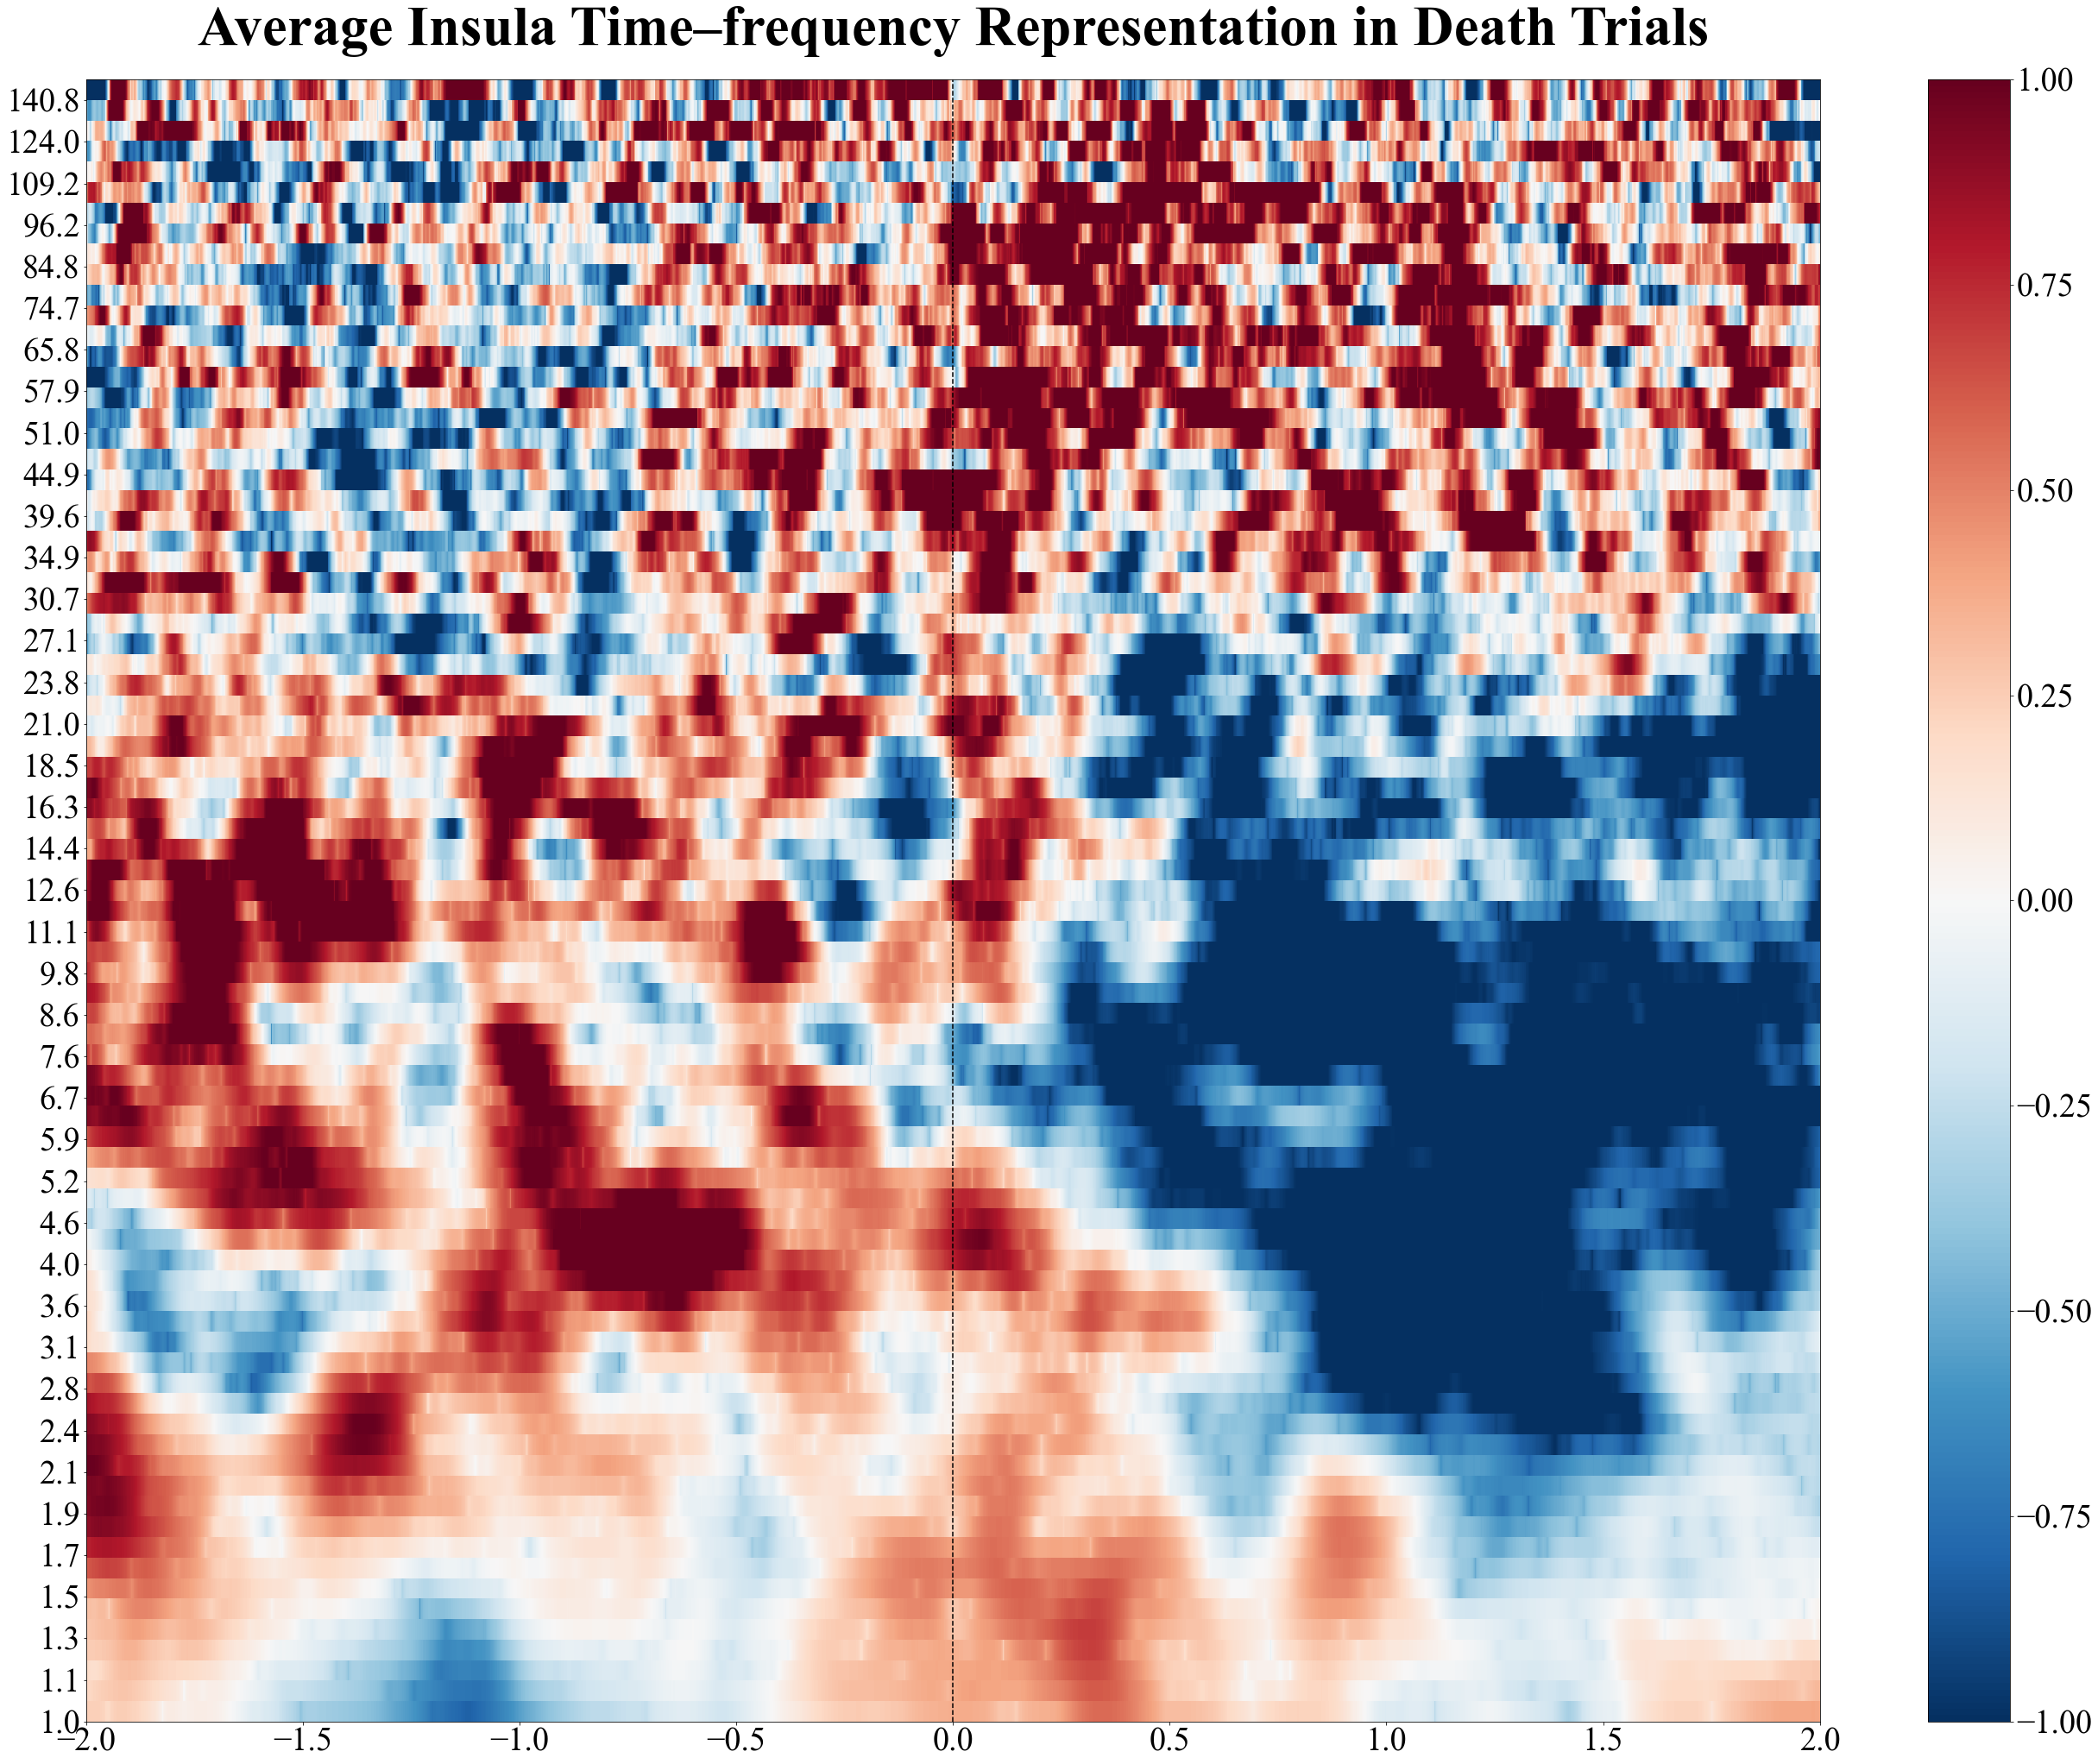

In [27]:
plot_allsub_averages(all_subs_average_insula_die, "Average Insula Time–frequency Representation in Death Trials", 'average_insula_death_all_subs.png')

## EC

In [28]:
all_subs_average_ecs = calculate_trial_end_average(sub_list, conditions, 'ec')
all_subs_average_ec_escape = all_subs_average_ecs[0]
all_subs_average_ec_chase = all_subs_average_ecs[1]
all_subs_average_ec_die = all_subs_average_ecs[2]

currently used subs: []
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/trial_end/ec-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/trial_end/ec-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/trial_end/ec-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'BJH016', 'SLCH002']
currently used subs: ['BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH027/ieeg/trial_end/ec-tfr.h5 ...
Adding metadata with 6 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'BJH016', 'SLCH002', 'BJH027']
Reading /home/brooke/kni

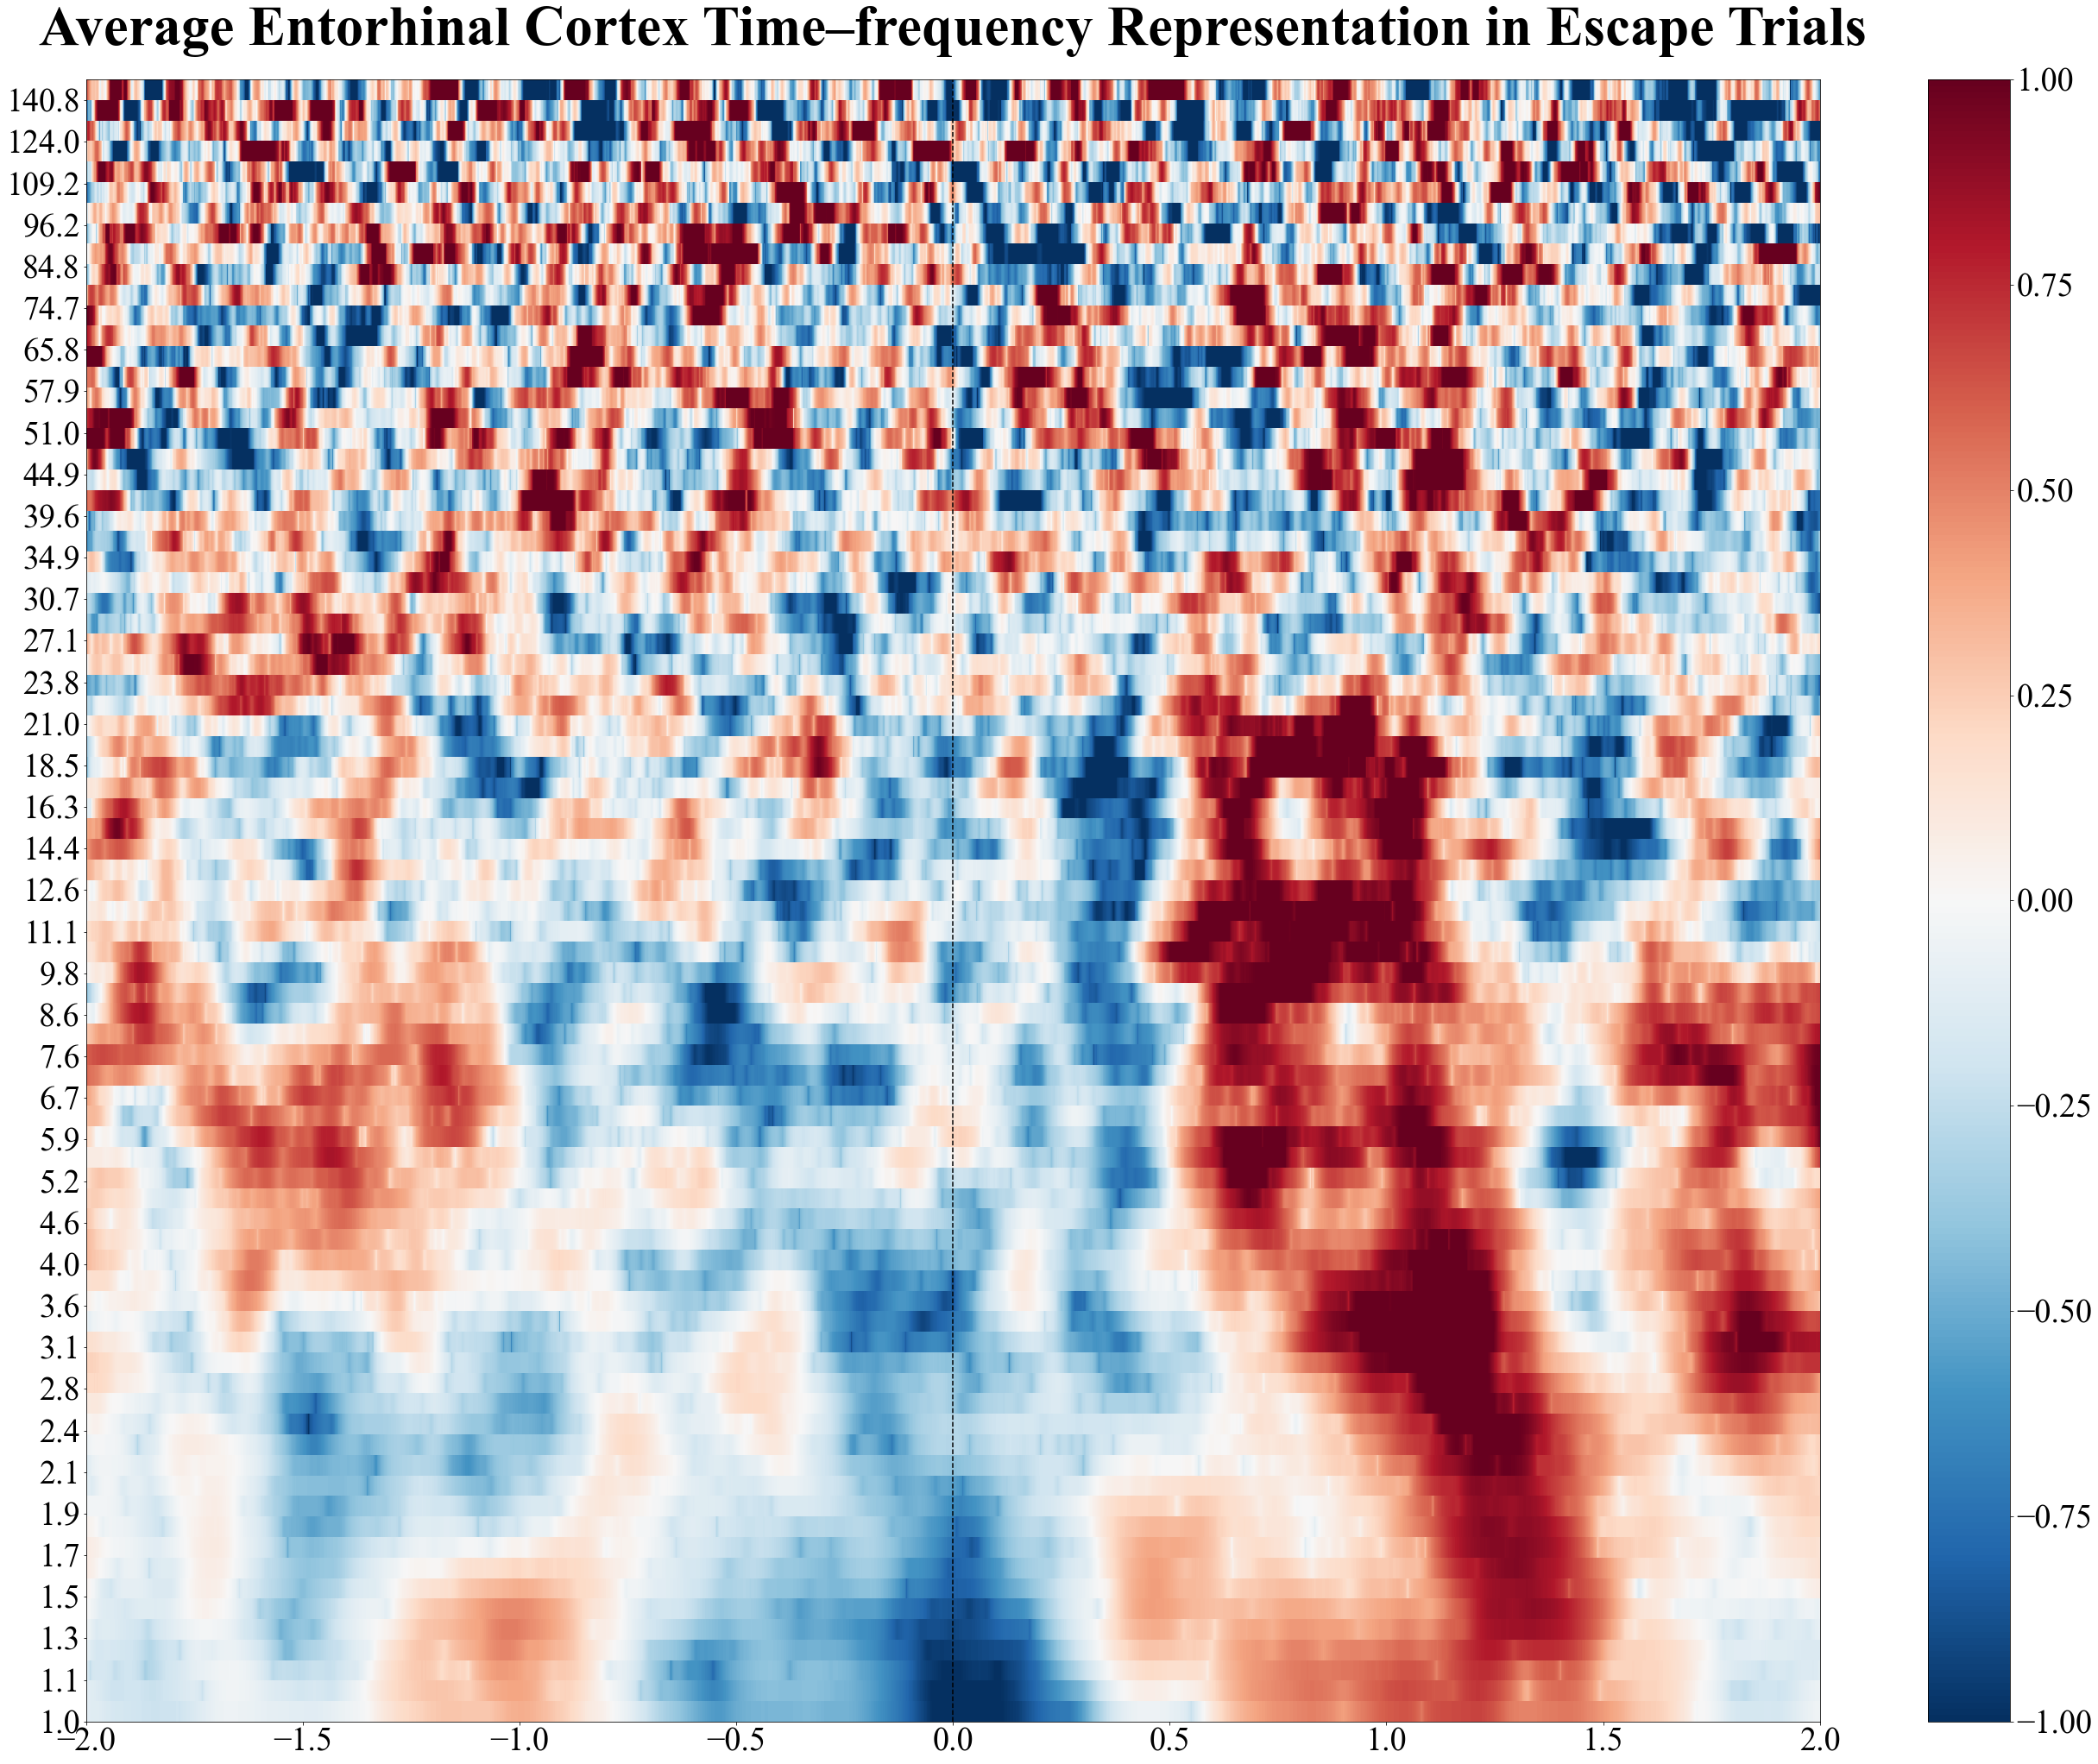

In [29]:
plot_allsub_averages(all_subs_average_ec_escape, "Average Entorhinal Cortex Time–frequency Representation in Escape Trials", 'average_ec_escape_all_subs.png')

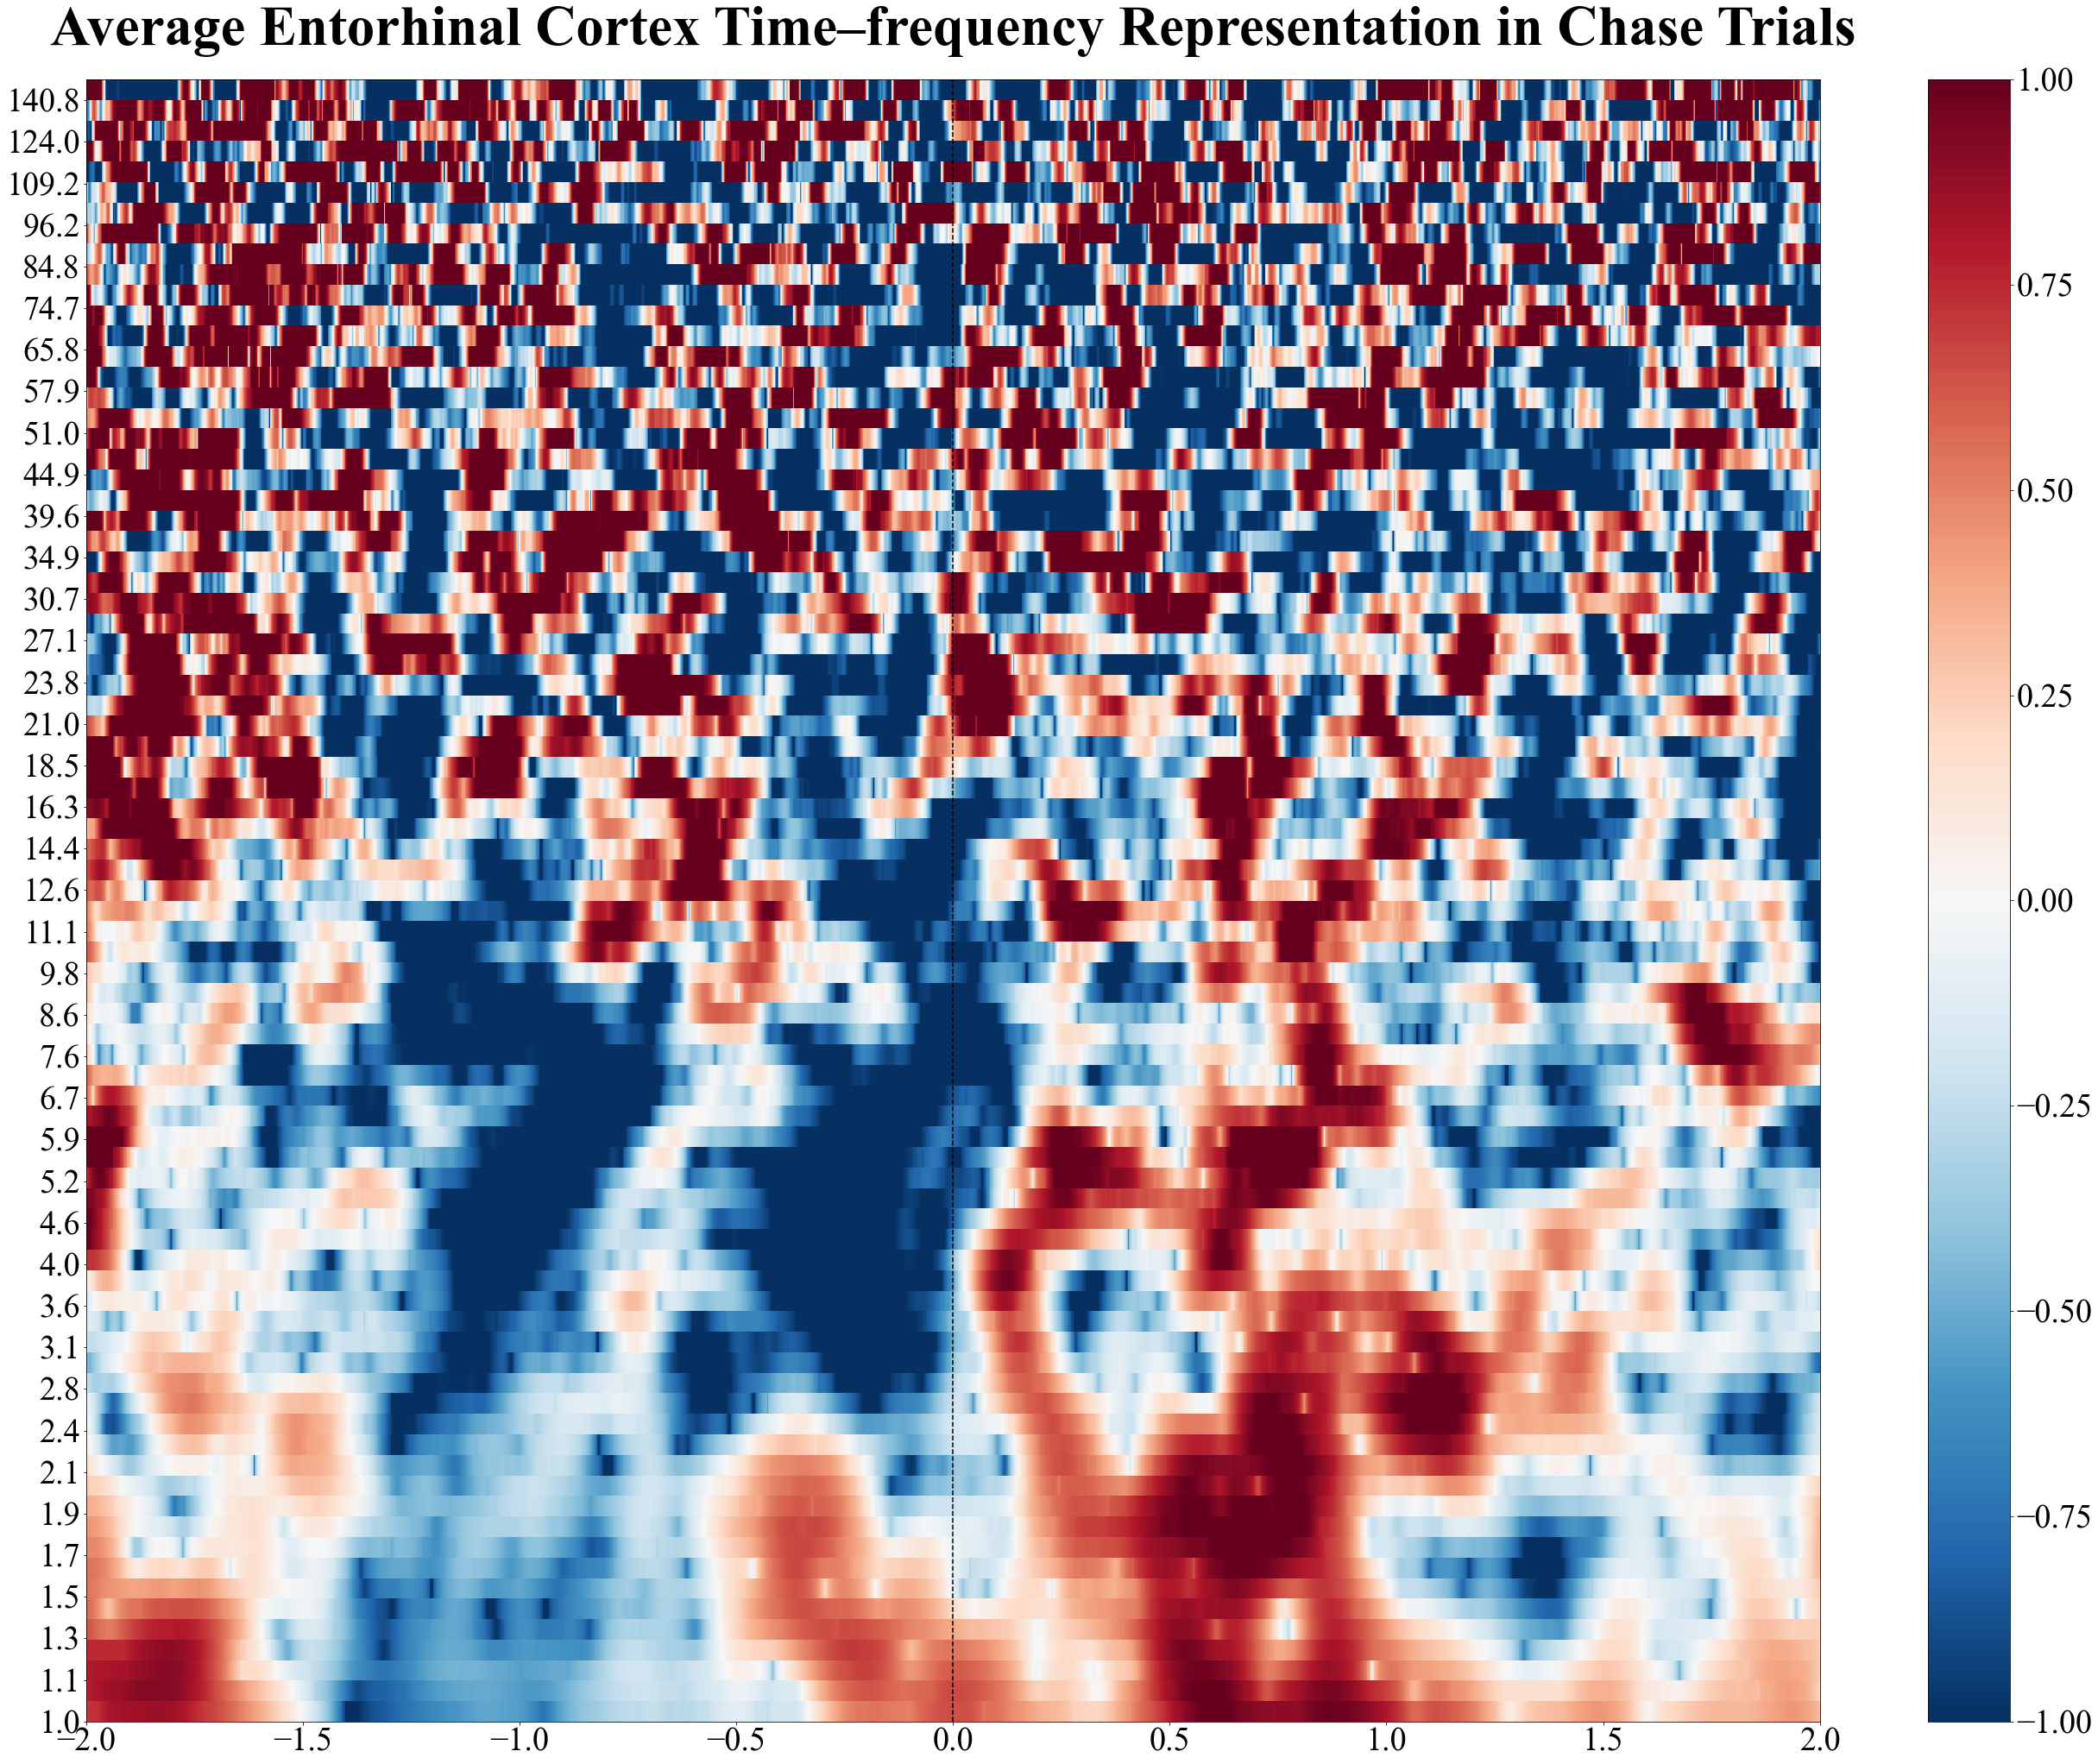

In [30]:
plot_allsub_averages(all_subs_average_ec_chase, "Average Entorhinal Cortex Time–frequency Representation in Chase Trials", 'average_ec_chase_all_subs.png')

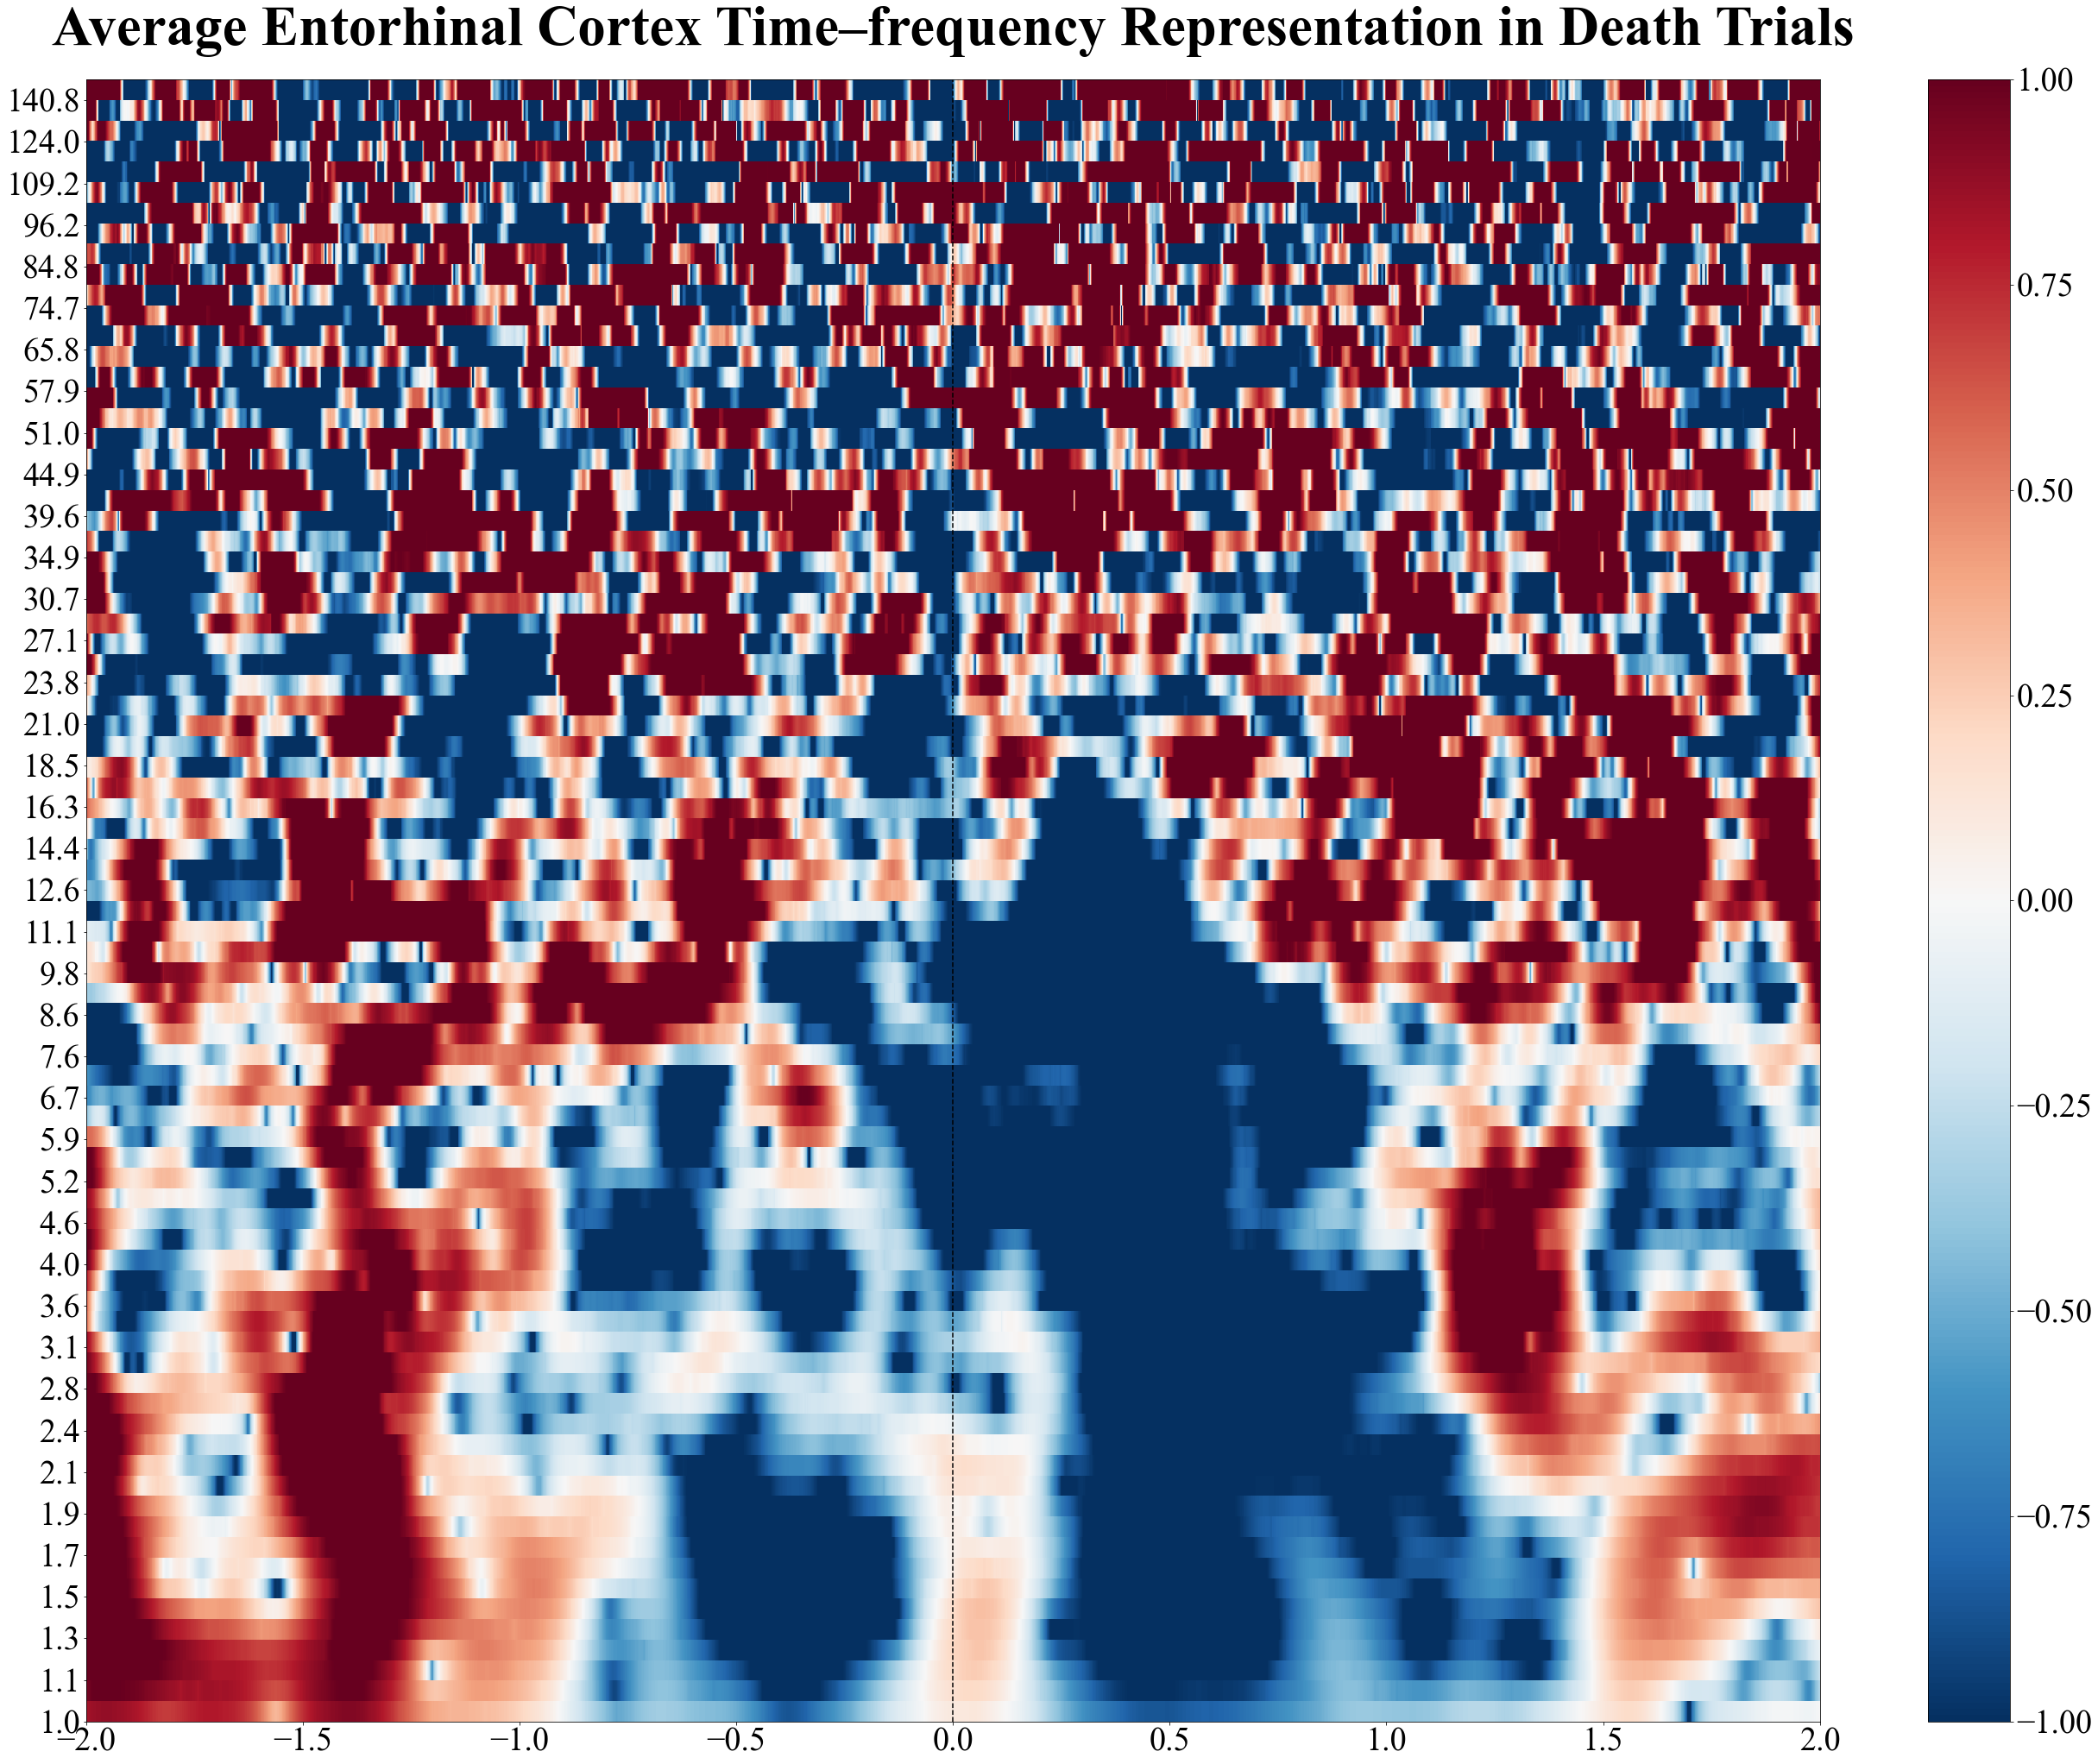

In [31]:
plot_allsub_averages(all_subs_average_ec_die, "Average Entorhinal Cortex Time–frequency Representation in Death Trials", 'average_ec_death_all_subs.png')